# 1. load data

In [20]:
import os
import random
import numpy as np
import torch
import torch.utils.data as Data
from torch import optim
import torch.nn.functional as F
from torch.autograd import Variable

import pypianoroll as ppr
import pretty_midi
from pypianoroll import Multitrack, Track
from matplotlib import pyplot as plt

In [21]:
from vae_rnn import *

In [22]:
random.seed(0)

In [23]:
train_xs = [ x for x in os.listdir('./../explore_data/data') if '.npy' in x ] 
for i, x in enumerate(train_xs):
    print('[{}]: {}'.format(i, x)) 

[0]: train_x_drum_reduced_World.npy
[1]: train_x_drum_reduced_Country.npy
[2]: train_x_drum_reduced_Punk.npy
[3]: train_x_drum_reduced_Folk.npy
[4]: train_x_drum_reduced_Pop.npy
[5]: train_x_drum_reduced_New-Age.npy
[6]: train_x_drum_reduced_Rock.npy
[7]: train_x_drum_reduced_Metal.npy
[8]: train_x_drum_reduced_Latin.npy
[9]: train_x_drum_reduced_Blues.npy
[10]: train_x_drum_reduced_Electronic.npy
[11]: train_x_drum_reduced_RnB.npy
[12]: train_x_drum_reduced_Rap.npy
[13]: train_x_drum_reduced_Reggae.npy
[14]: train_x_drum_reduced_Jazz.npy


In [24]:
prefix = './../explore_data/data/'
train_x_reduced = np.zeros((0,SEQ_LEN,NUM_FEATURES))

for i, fn in enumerate(train_xs):
    data = np.load(prefix + fn)
    train_x_reduced = np.vstack((train_x_reduced, data))

print(train_x_reduced.shape)

(392836, 96, 9)


In [25]:
LR = 0.015
NUM_EPOCHS = 100
BATCH_SIZE = 256
BETA = 15.0
BEAT = 48

TESTING_RATIO = 0.05
N_DATA = train_x_reduced.shape[0]
N_TRAINING = int(train_x_reduced.shape[0]*TESTING_RATIO)
N_TESTING = N_DATA - N_TRAINING

In [26]:
def pltReducedDrumTrack(track, beat_resolution=12, cmap='Blues'):
    track = np.append(track, np.zeros((track.shape[0], 119)), axis=1)
    # track = np.where(track == 1, 128, 0)
    track = track * 128
    track = Track(pianoroll=track)
    
    fig, axs = track.plot(
        xtick='beat',
        yticklabel='number',
        beat_resolution=beat_resolution,
        cmap=cmap,
    )
    fig.set_size_inches(30,10)
    y = axs.set_ylim(0, 10) # C0 - C2
    y = axs.set_yticks(range(10))
    plt.show()

In [27]:
def parse_data(training_data):
    ratio = TESTING_RATIO
    T = int(training_data.shape[0]*ratio)
    
    train_x = training_data[:-T]
    test_x = training_data[-T:]

    train_x = torch.from_numpy(train_x).type(torch.FloatTensor)
    test_x = torch.from_numpy(test_x).type(torch.FloatTensor)
    
    return train_x, test_x

# 2. training

In [28]:
train_x, test_x = parse_data(train_x_reduced)
train_dataset = Data.TensorDataset(train_x)
test_dataset = Data.TensorDataset(test_x)

train_loader = Data.DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True,
    num_workers=1,
)
test_loader = Data.DataLoader(
    dataset=test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True,
    num_workers=1,
)

In [29]:
encoder = Encoder().to(device)
decoder = Decoder(beat=BEAT).to(device)
vae = VAE(encoder, decoder).to(device)

optimizer = optim.Adam(vae.parameters(), lr=LR)
test_err = 0

In [ ]:
for epoch in range(NUM_EPOCHS):
    loss_sum = 0
    bce_sum = 0
    kld_sum = 0
    for batch_i, data in enumerate(train_loader):
        data = Variable(data[0]).type(torch.float32).to(device)
        optimizer.zero_grad()
        data_out = vae(data)
        
        loss, bce, kld = elbo(
            data_out,
            data,
            vae.z_mean,
            vae.z_sigma,
            beta=BETA
        )
        loss.backward()
        optimizer.step()

        loss_sum += loss.data.item()
        bce_sum += bce.data.item()
        kld_sum += kld.data.item()
        
        if batch_i % 5 == 0:
            print('Train Epoch: {} [{:4d}/{} ({:2.0f}%)]      Loss: {:.6f}'.format(
                epoch,
                batch_i * BATCH_SIZE,
                len(train_loader.dataset),
                100. * batch_i / len(train_loader),
                loss.data.item() / BATCH_SIZE))
            print('bce: {:.6f}, kld: {:.6f}'.format(
                bce.data.item() / BATCH_SIZE,
                kld.data.item() / BATCH_SIZE))
    print('====> Epoch: {} Average loss: {:.4f}, bce: {:.4f}, kld: {:.4f}'.format(
        epoch, loss_sum / len(train_loader.dataset),
        bce_sum / len(train_loader.dataset),
        kld_sum / len(train_loader.dataset),
    ))
    
    if epoch % 5 == 0:
        loss_sum_test = 0
        for batch_i, data in enumerate(test_loader):
            with torch.no_grad():
                data = Variable(data[0]).type(torch.float32).to(device)
                data_out = vae(data)

                loss = F.binary_cross_entropy(
                    data_out,
                    data,
                    reduction='sum'
                )
                loss_sum_test += loss.item()

        print('====> Testing Average Loss: {}'.format(
            loss_sum_test / len(test_loader.dataset)))
        test_err = loss_sum_test / len(test_loader.dataset)

Train Epoch: 0 [   0/373195 ( 0%)]      Loss: 1742.940674
bce: 545.079468, kld: 79.857414
Train Epoch: 0 [1280/373195 ( 0%)]      Loss: 856.398926
bce: 510.005310, kld: 23.092905
Train Epoch: 0 [2560/373195 ( 1%)]      Loss: 700.524780
bce: 485.017914, kld: 14.367126
Train Epoch: 0 [3840/373195 ( 1%)]      Loss: 590.721680
bce: 462.330719, kld: 8.559398
Train Epoch: 0 [5120/373195 ( 1%)]      Loss: 515.540833
bce: 441.301514, kld: 4.949286
Train Epoch: 0 [6400/373195 ( 2%)]      Loss: 465.978760
bce: 419.759064, kld: 3.081313
Train Epoch: 0 [7680/373195 ( 2%)]      Loss: 431.448822
bce: 400.731384, kld: 2.047830
Train Epoch: 0 [8960/373195 ( 2%)]      Loss: 403.308105
bce: 380.035980, kld: 1.551474
Train Epoch: 0 [10240/373195 ( 3%)]      Loss: 379.343781
bce: 361.655579, kld: 1.179214
Train Epoch: 0 [11520/373195 ( 3%)]      Loss: 358.044434
bce: 345.001526, kld: 0.869526
Train Epoch: 0 [12800/373195 ( 3%)]      Loss: 338.357483
bce: 327.206268, kld: 0.743414
Train Epoch: 0 [14080/373

Train Epoch: 0 [120320/373195 (32%)]      Loss: 68.901604
bce: 63.883713, kld: 0.334526
Train Epoch: 0 [121600/373195 (33%)]      Loss: 70.099571
bce: 65.331665, kld: 0.317860
Train Epoch: 0 [122880/373195 (33%)]      Loss: 65.707993
bce: 59.373596, kld: 0.422293
Train Epoch: 0 [124160/373195 (33%)]      Loss: 65.962898
bce: 60.702309, kld: 0.350706
Train Epoch: 0 [125440/373195 (34%)]      Loss: 71.386604
bce: 61.990276, kld: 0.626422
Train Epoch: 0 [126720/373195 (34%)]      Loss: 70.604309
bce: 64.159622, kld: 0.429646
Train Epoch: 0 [128000/373195 (34%)]      Loss: 65.273399
bce: 58.151833, kld: 0.474771
Train Epoch: 0 [129280/373195 (35%)]      Loss: 63.887203
bce: 58.169579, kld: 0.381175
Train Epoch: 0 [130560/373195 (35%)]      Loss: 60.256416
bce: 55.311844, kld: 0.329638
Train Epoch: 0 [131840/373195 (35%)]      Loss: 60.395355
bce: 56.168652, kld: 0.281780
Train Epoch: 0 [133120/373195 (36%)]      Loss: 67.609062
bce: 58.547142, kld: 0.604128
Train Epoch: 0 [134400/373195 (3

Train Epoch: 0 [240640/373195 (65%)]      Loss: 48.103714
bce: 47.313454, kld: 0.052684
Train Epoch: 0 [241920/373195 (65%)]      Loss: 46.508606
bce: 45.942917, kld: 0.037713
Train Epoch: 0 [243200/373195 (65%)]      Loss: 47.969776
bce: 46.802483, kld: 0.077820
Train Epoch: 0 [244480/373195 (66%)]      Loss: 49.023899
bce: 46.605743, kld: 0.161210
Train Epoch: 0 [245760/373195 (66%)]      Loss: 45.879330
bce: 45.367416, kld: 0.034127
Train Epoch: 0 [247040/373195 (66%)]      Loss: 45.778324
bce: 45.335068, kld: 0.029550
Train Epoch: 0 [248320/373195 (67%)]      Loss: 45.707653
bce: 45.262459, kld: 0.029680
Train Epoch: 0 [249600/373195 (67%)]      Loss: 46.037903
bce: 44.514702, kld: 0.101547
Train Epoch: 0 [250880/373195 (67%)]      Loss: 45.257801
bce: 44.229012, kld: 0.068586
Train Epoch: 0 [252160/373195 (68%)]      Loss: 52.244175
bce: 48.048344, kld: 0.279722
Train Epoch: 0 [253440/373195 (68%)]      Loss: 46.079617
bce: 42.987991, kld: 0.206108
Train Epoch: 0 [254720/373195 (6

Train Epoch: 0 [360960/373195 (97%)]      Loss: 38.655697
bce: 38.376259, kld: 0.018629
Train Epoch: 0 [362240/373195 (97%)]      Loss: 38.598610
bce: 37.726368, kld: 0.058150
Train Epoch: 0 [363520/373195 (97%)]      Loss: 41.072281
bce: 40.725372, kld: 0.023127
Train Epoch: 0 [364800/373195 (98%)]      Loss: 40.459263
bce: 40.104004, kld: 0.023684
Train Epoch: 0 [366080/373195 (98%)]      Loss: 38.805904
bce: 38.491638, kld: 0.020951
Train Epoch: 0 [367360/373195 (98%)]      Loss: 41.520420
bce: 39.742367, kld: 0.118537
Train Epoch: 0 [368640/373195 (99%)]      Loss: 41.791988
bce: 41.409584, kld: 0.025494
Train Epoch: 0 [369920/373195 (99%)]      Loss: 37.857307
bce: 37.478420, kld: 0.025259
Train Epoch: 0 [371200/373195 (100%)]      Loss: 37.701645
bce: 37.141418, kld: 0.037348
Train Epoch: 0 [372480/373195 (100%)]      Loss: 37.884502
bce: 37.520191, kld: 0.024287
====> Epoch: 0 Average loss: 94.5216, bce: 81.2092, kld: 0.8875
====> Testing Average Loss: 43.60116060830978
Train Ep

Train Epoch: 1 [106240/373195 (28%)]      Loss: 38.272198
bce: 38.085781, kld: 0.012428
Train Epoch: 1 [107520/373195 (29%)]      Loss: 33.944004
bce: 33.777477, kld: 0.011102
Train Epoch: 1 [108800/373195 (29%)]      Loss: 37.567081
bce: 37.413902, kld: 0.010212
Train Epoch: 1 [110080/373195 (30%)]      Loss: 36.787743
bce: 36.482033, kld: 0.020381
Train Epoch: 1 [111360/373195 (30%)]      Loss: 37.831467
bce: 37.682899, kld: 0.009905
Train Epoch: 1 [112640/373195 (30%)]      Loss: 36.262009
bce: 36.100655, kld: 0.010757
Train Epoch: 1 [113920/373195 (31%)]      Loss: 34.185085
bce: 34.030697, kld: 0.010293
Train Epoch: 1 [115200/373195 (31%)]      Loss: 36.939995
bce: 36.685001, kld: 0.017000
Train Epoch: 1 [116480/373195 (31%)]      Loss: 34.572063
bce: 34.305901, kld: 0.017744
Train Epoch: 1 [117760/373195 (32%)]      Loss: 35.689060
bce: 35.422150, kld: 0.017794
Train Epoch: 1 [119040/373195 (32%)]      Loss: 38.776039
bce: 38.436546, kld: 0.022633
Train Epoch: 1 [120320/373195 (3

Train Epoch: 1 [227840/373195 (61%)]      Loss: 35.269413
bce: 35.121971, kld: 0.009830
Train Epoch: 1 [229120/373195 (61%)]      Loss: 32.484150
bce: 32.364807, kld: 0.007956
Train Epoch: 1 [230400/373195 (62%)]      Loss: 34.297356
bce: 34.183388, kld: 0.007598
Train Epoch: 1 [231680/373195 (62%)]      Loss: 34.070774
bce: 33.961704, kld: 0.007271
Train Epoch: 1 [232960/373195 (62%)]      Loss: 34.613991
bce: 34.509136, kld: 0.006990
Train Epoch: 1 [234240/373195 (63%)]      Loss: 34.476143
bce: 34.381905, kld: 0.006282
Train Epoch: 1 [235520/373195 (63%)]      Loss: 32.723324
bce: 32.635025, kld: 0.005887
Train Epoch: 1 [236800/373195 (63%)]      Loss: 33.400154
bce: 33.318367, kld: 0.005452
Train Epoch: 1 [238080/373195 (64%)]      Loss: 37.610027
bce: 37.507240, kld: 0.006852
Train Epoch: 1 [239360/373195 (64%)]      Loss: 32.661716
bce: 32.497498, kld: 0.010948
Train Epoch: 1 [240640/373195 (65%)]      Loss: 37.055565
bce: 36.951439, kld: 0.006942
Train Epoch: 1 [241920/373195 (6

Train Epoch: 1 [348160/373195 (93%)]      Loss: 33.947628
bce: 33.847694, kld: 0.006662
Train Epoch: 1 [349440/373195 (94%)]      Loss: 31.910393
bce: 31.816460, kld: 0.006262
Train Epoch: 1 [350720/373195 (94%)]      Loss: 32.999950
bce: 32.906750, kld: 0.006213
Train Epoch: 1 [352000/373195 (94%)]      Loss: 34.502544
bce: 34.397015, kld: 0.007035
Train Epoch: 1 [353280/373195 (95%)]      Loss: 34.220833
bce: 34.114861, kld: 0.007065
Train Epoch: 1 [354560/373195 (95%)]      Loss: 34.962513
bce: 34.851700, kld: 0.007387
Train Epoch: 1 [355840/373195 (95%)]      Loss: 32.431591
bce: 32.301445, kld: 0.008676
Train Epoch: 1 [357120/373195 (96%)]      Loss: 33.760296
bce: 33.624779, kld: 0.009034
Train Epoch: 1 [358400/373195 (96%)]      Loss: 32.872761
bce: 32.739395, kld: 0.008891
Train Epoch: 1 [359680/373195 (96%)]      Loss: 33.659718
bce: 33.540817, kld: 0.007927
Train Epoch: 1 [360960/373195 (97%)]      Loss: 33.350170
bce: 33.252670, kld: 0.006500
Train Epoch: 1 [362240/373195 (9

Train Epoch: 2 [94720/373195 (25%)]      Loss: 30.003586
bce: 29.927750, kld: 0.005056
Train Epoch: 2 [96000/373195 (26%)]      Loss: 29.338354
bce: 29.266850, kld: 0.004767
Train Epoch: 2 [97280/373195 (26%)]      Loss: 32.656784
bce: 32.561211, kld: 0.006372
Train Epoch: 2 [98560/373195 (26%)]      Loss: 31.682522
bce: 31.618670, kld: 0.004257
Train Epoch: 2 [99840/373195 (27%)]      Loss: 33.250935
bce: 33.181259, kld: 0.004645
Train Epoch: 2 [101120/373195 (27%)]      Loss: 30.600382
bce: 30.531193, kld: 0.004613
Train Epoch: 2 [102400/373195 (27%)]      Loss: 29.487921
bce: 29.418093, kld: 0.004655
Train Epoch: 2 [103680/373195 (28%)]      Loss: 31.550001
bce: 31.474495, kld: 0.005034
Train Epoch: 2 [104960/373195 (28%)]      Loss: 37.182701
bce: 36.663486, kld: 0.034614
Train Epoch: 2 [106240/373195 (28%)]      Loss: 30.492767
bce: 30.375729, kld: 0.007803
Train Epoch: 2 [107520/373195 (29%)]      Loss: 32.861908
bce: 32.716496, kld: 0.009694
Train Epoch: 2 [108800/373195 (29%)] 

Train Epoch: 2 [215040/373195 (58%)]      Loss: 31.816122
bce: 31.738594, kld: 0.005169
Train Epoch: 2 [216320/373195 (58%)]      Loss: 32.777660
bce: 32.701752, kld: 0.005061
Train Epoch: 2 [217600/373195 (58%)]      Loss: 30.449713
bce: 30.375736, kld: 0.004932
Train Epoch: 2 [218880/373195 (59%)]      Loss: 30.757345
bce: 30.677425, kld: 0.005328
Train Epoch: 2 [220160/373195 (59%)]      Loss: 31.025620
bce: 30.944546, kld: 0.005405
Train Epoch: 2 [221440/373195 (59%)]      Loss: 31.513676
bce: 31.423126, kld: 0.006037
Train Epoch: 2 [222720/373195 (60%)]      Loss: 30.612915
bce: 30.520267, kld: 0.006176
Train Epoch: 2 [224000/373195 (60%)]      Loss: 32.287640
bce: 32.174522, kld: 0.007541
Train Epoch: 2 [225280/373195 (60%)]      Loss: 34.309429
bce: 34.190224, kld: 0.007947
Train Epoch: 2 [226560/373195 (61%)]      Loss: 29.210720
bce: 29.106556, kld: 0.006944
Train Epoch: 2 [227840/373195 (61%)]      Loss: 32.356224
bce: 32.262661, kld: 0.006238
Train Epoch: 2 [229120/373195 (6

Train Epoch: 2 [335360/373195 (90%)]      Loss: 29.380203
bce: 29.254044, kld: 0.008411
Train Epoch: 2 [336640/373195 (90%)]      Loss: 30.082457
bce: 29.963974, kld: 0.007899
Train Epoch: 2 [337920/373195 (91%)]      Loss: 29.832775
bce: 29.727108, kld: 0.007044
Train Epoch: 2 [339200/373195 (91%)]      Loss: 28.019707
bce: 27.917450, kld: 0.006817
Train Epoch: 2 [340480/373195 (91%)]      Loss: 32.602844
bce: 32.491100, kld: 0.007450
Train Epoch: 2 [341760/373195 (92%)]      Loss: 29.344290
bce: 29.241394, kld: 0.006860
Train Epoch: 2 [343040/373195 (92%)]      Loss: 30.077749
bce: 29.970068, kld: 0.007179
Train Epoch: 2 [344320/373195 (92%)]      Loss: 29.254005
bce: 29.151405, kld: 0.006840
Train Epoch: 2 [345600/373195 (93%)]      Loss: 30.574093
bce: 30.470766, kld: 0.006888
Train Epoch: 2 [346880/373195 (93%)]      Loss: 28.981043
bce: 28.880707, kld: 0.006689
Train Epoch: 2 [348160/373195 (93%)]      Loss: 31.508667
bce: 31.414234, kld: 0.006295
Train Epoch: 2 [349440/373195 (9

Train Epoch: 3 [81920/373195 (22%)]      Loss: 28.614815
bce: 28.477386, kld: 0.009162
Train Epoch: 3 [83200/373195 (22%)]      Loss: 29.694914
bce: 29.548569, kld: 0.009756
Train Epoch: 3 [84480/373195 (23%)]      Loss: 32.206512
bce: 32.072952, kld: 0.008904
Train Epoch: 3 [85760/373195 (23%)]      Loss: 30.043257
bce: 29.917360, kld: 0.008393
Train Epoch: 3 [87040/373195 (23%)]      Loss: 27.358498
bce: 27.247269, kld: 0.007415
Train Epoch: 3 [88320/373195 (24%)]      Loss: 29.004847
bce: 28.884949, kld: 0.007993
Train Epoch: 3 [89600/373195 (24%)]      Loss: 27.405384
bce: 27.311062, kld: 0.006288
Train Epoch: 3 [90880/373195 (24%)]      Loss: 29.533421
bce: 29.445444, kld: 0.005865
Train Epoch: 3 [92160/373195 (25%)]      Loss: 27.574383
bce: 27.478872, kld: 0.006367
Train Epoch: 3 [93440/373195 (25%)]      Loss: 32.085999
bce: 31.968460, kld: 0.007836
Train Epoch: 3 [94720/373195 (25%)]      Loss: 28.690527
bce: 28.578260, kld: 0.007484
Train Epoch: 3 [96000/373195 (26%)]      Lo

Train Epoch: 3 [202240/373195 (54%)]      Loss: 29.581963
bce: 29.469378, kld: 0.007506
Train Epoch: 3 [203520/373195 (55%)]      Loss: 26.677608
bce: 26.557652, kld: 0.007997
Train Epoch: 3 [204800/373195 (55%)]      Loss: 29.023329
bce: 28.909153, kld: 0.007612
Train Epoch: 3 [206080/373195 (55%)]      Loss: 29.674252
bce: 29.559681, kld: 0.007638
Train Epoch: 3 [207360/373195 (56%)]      Loss: 28.973993
bce: 28.862698, kld: 0.007420
Train Epoch: 3 [208640/373195 (56%)]      Loss: 28.777887
bce: 28.657375, kld: 0.008034
Train Epoch: 3 [209920/373195 (56%)]      Loss: 27.860901
bce: 27.727913, kld: 0.008866
Train Epoch: 3 [211200/373195 (57%)]      Loss: 27.800512
bce: 27.670000, kld: 0.008701
Train Epoch: 3 [212480/373195 (57%)]      Loss: 28.975021
bce: 28.844238, kld: 0.008719
Train Epoch: 3 [213760/373195 (57%)]      Loss: 28.957542
bce: 28.833820, kld: 0.008248
Train Epoch: 3 [215040/373195 (58%)]      Loss: 29.082758
bce: 28.964432, kld: 0.007888
Train Epoch: 3 [216320/373195 (5

Train Epoch: 3 [323840/373195 (87%)]      Loss: 28.276596
bce: 28.162840, kld: 0.007584
Train Epoch: 3 [325120/373195 (87%)]      Loss: 27.640783
bce: 27.533230, kld: 0.007170
Train Epoch: 3 [326400/373195 (88%)]      Loss: 30.143368
bce: 30.041788, kld: 0.006772
Train Epoch: 3 [327680/373195 (88%)]      Loss: 28.284781
bce: 28.187977, kld: 0.006454
Train Epoch: 3 [328960/373195 (88%)]      Loss: 31.153439
bce: 31.062740, kld: 0.006047
Train Epoch: 3 [330240/373195 (89%)]      Loss: 27.661722
bce: 27.551615, kld: 0.007340
Train Epoch: 3 [331520/373195 (89%)]      Loss: 30.114862
bce: 30.002331, kld: 0.007502
Train Epoch: 3 [332800/373195 (89%)]      Loss: 27.018406
bce: 26.895311, kld: 0.008206
Train Epoch: 3 [334080/373195 (90%)]      Loss: 29.410223
bce: 29.276756, kld: 0.008898
Train Epoch: 3 [335360/373195 (90%)]      Loss: 27.272394
bce: 27.140776, kld: 0.008775
Train Epoch: 3 [336640/373195 (90%)]      Loss: 30.540123
bce: 30.424343, kld: 0.007719
Train Epoch: 3 [337920/373195 (9

Train Epoch: 4 [71680/373195 (19%)]      Loss: 28.733692
bce: 28.604986, kld: 0.008580
Train Epoch: 4 [72960/373195 (20%)]      Loss: 27.537277
bce: 27.396954, kld: 0.009355
Train Epoch: 4 [74240/373195 (20%)]      Loss: 27.665552
bce: 27.523376, kld: 0.009478
Train Epoch: 4 [75520/373195 (20%)]      Loss: 28.305853
bce: 28.178661, kld: 0.008479
Train Epoch: 4 [76800/373195 (21%)]      Loss: 28.854433
bce: 28.713110, kld: 0.009422
Train Epoch: 4 [78080/373195 (21%)]      Loss: 29.519142
bce: 29.394321, kld: 0.008321
Train Epoch: 4 [79360/373195 (21%)]      Loss: 30.407175
bce: 30.283489, kld: 0.008246
Train Epoch: 4 [80640/373195 (22%)]      Loss: 27.744270
bce: 27.629126, kld: 0.007676
Train Epoch: 4 [81920/373195 (22%)]      Loss: 27.489456
bce: 27.366096, kld: 0.008224
Train Epoch: 4 [83200/373195 (22%)]      Loss: 29.405426
bce: 29.286650, kld: 0.007918
Train Epoch: 4 [84480/373195 (23%)]      Loss: 29.221270
bce: 29.073135, kld: 0.009876
Train Epoch: 4 [85760/373195 (23%)]      Lo

Train Epoch: 4 [193280/373195 (52%)]      Loss: 26.340040
bce: 26.201763, kld: 0.009218
Train Epoch: 4 [194560/373195 (52%)]      Loss: 27.370623
bce: 27.219475, kld: 0.010077
Train Epoch: 4 [195840/373195 (53%)]      Loss: 28.093864
bce: 27.925220, kld: 0.011243
Train Epoch: 4 [197120/373195 (53%)]      Loss: 27.891708
bce: 27.718204, kld: 0.011567
Train Epoch: 4 [198400/373195 (53%)]      Loss: 29.260658
bce: 29.101830, kld: 0.010589
Train Epoch: 4 [199680/373195 (54%)]      Loss: 26.556492
bce: 26.402863, kld: 0.010242
Train Epoch: 4 [200960/373195 (54%)]      Loss: 29.249443
bce: 29.093952, kld: 0.010366
Train Epoch: 4 [202240/373195 (54%)]      Loss: 31.363817
bce: 31.216030, kld: 0.009853
Train Epoch: 4 [203520/373195 (55%)]      Loss: 30.055424
bce: 29.913731, kld: 0.009446
Train Epoch: 4 [204800/373195 (55%)]      Loss: 28.443565
bce: 28.322903, kld: 0.008044
Train Epoch: 4 [206080/373195 (55%)]      Loss: 26.850918
bce: 26.711128, kld: 0.009319
Train Epoch: 4 [207360/373195 (5

Train Epoch: 4 [316160/373195 (85%)]      Loss: 29.785711
bce: 29.618769, kld: 0.011130
Train Epoch: 4 [317440/373195 (85%)]      Loss: 27.098186
bce: 26.947186, kld: 0.010067
Train Epoch: 4 [318720/373195 (85%)]      Loss: 25.193594
bce: 25.042034, kld: 0.010104
Train Epoch: 4 [320000/373195 (86%)]      Loss: 28.533243
bce: 28.395683, kld: 0.009171
Train Epoch: 4 [321280/373195 (86%)]      Loss: 30.007732
bce: 29.867456, kld: 0.009352
Train Epoch: 4 [322560/373195 (86%)]      Loss: 27.979080
bce: 27.847507, kld: 0.008772
Train Epoch: 4 [323840/373195 (87%)]      Loss: 25.496572
bce: 25.377651, kld: 0.007928
Train Epoch: 4 [325120/373195 (87%)]      Loss: 29.790037
bce: 29.663460, kld: 0.008439
Train Epoch: 4 [326400/373195 (88%)]      Loss: 28.504641
bce: 28.387129, kld: 0.007834
Train Epoch: 4 [327680/373195 (88%)]      Loss: 30.198486
bce: 30.067173, kld: 0.008754
Train Epoch: 4 [328960/373195 (88%)]      Loss: 27.388142
bce: 27.246462, kld: 0.009445
Train Epoch: 4 [330240/373195 (8

Train Epoch: 5 [61440/373195 (16%)]      Loss: 27.854378
bce: 27.706215, kld: 0.009877
Train Epoch: 5 [62720/373195 (17%)]      Loss: 28.581505
bce: 28.437759, kld: 0.009583
Train Epoch: 5 [64000/373195 (17%)]      Loss: 27.414362
bce: 27.286583, kld: 0.008519
Train Epoch: 5 [65280/373195 (18%)]      Loss: 27.285177
bce: 27.168167, kld: 0.007801
Train Epoch: 5 [66560/373195 (18%)]      Loss: 27.982847
bce: 27.855774, kld: 0.008472
Train Epoch: 5 [67840/373195 (18%)]      Loss: 26.419306
bce: 26.286665, kld: 0.008843
Train Epoch: 5 [69120/373195 (19%)]      Loss: 28.919647
bce: 28.781710, kld: 0.009196
Train Epoch: 5 [70400/373195 (19%)]      Loss: 27.820625
bce: 27.681122, kld: 0.009300
Train Epoch: 5 [71680/373195 (19%)]      Loss: 28.287851
bce: 28.134315, kld: 0.010236
Train Epoch: 5 [72960/373195 (20%)]      Loss: 29.732103
bce: 29.576031, kld: 0.010405
Train Epoch: 5 [74240/373195 (20%)]      Loss: 30.271097
bce: 30.116367, kld: 0.010315
Train Epoch: 5 [75520/373195 (20%)]      Lo

Train Epoch: 5 [183040/373195 (49%)]      Loss: 28.740341
bce: 28.584122, kld: 0.010415
Train Epoch: 5 [184320/373195 (49%)]      Loss: 26.968143
bce: 26.820303, kld: 0.009856
Train Epoch: 5 [185600/373195 (50%)]      Loss: 26.670420
bce: 26.543947, kld: 0.008431
Train Epoch: 5 [186880/373195 (50%)]      Loss: 28.288815
bce: 28.179337, kld: 0.007299
Train Epoch: 5 [188160/373195 (50%)]      Loss: 27.331629
bce: 27.233416, kld: 0.006548
Train Epoch: 5 [189440/373195 (51%)]      Loss: 25.947548
bce: 25.851337, kld: 0.006414
Train Epoch: 5 [190720/373195 (51%)]      Loss: 29.999130
bce: 29.890373, kld: 0.007250
Train Epoch: 5 [192000/373195 (51%)]      Loss: 26.405636
bce: 26.287609, kld: 0.007868
Train Epoch: 5 [193280/373195 (52%)]      Loss: 25.409510
bce: 25.274689, kld: 0.008988
Train Epoch: 5 [194560/373195 (52%)]      Loss: 25.694309
bce: 25.564888, kld: 0.008628
Train Epoch: 5 [195840/373195 (53%)]      Loss: 28.985798
bce: 28.841049, kld: 0.009650
Train Epoch: 5 [197120/373195 (5

Train Epoch: 5 [303360/373195 (81%)]      Loss: 29.935226
bce: 29.811220, kld: 0.008267
Train Epoch: 5 [304640/373195 (82%)]      Loss: 28.270786
bce: 28.146338, kld: 0.008297
Train Epoch: 5 [305920/373195 (82%)]      Loss: 27.613323
bce: 27.488735, kld: 0.008306
Train Epoch: 5 [307200/373195 (82%)]      Loss: 28.953619
bce: 28.837185, kld: 0.007762
Train Epoch: 5 [308480/373195 (83%)]      Loss: 26.440058
bce: 26.318932, kld: 0.008075
Train Epoch: 5 [309760/373195 (83%)]      Loss: 26.621737
bce: 26.501293, kld: 0.008030
Train Epoch: 5 [311040/373195 (83%)]      Loss: 26.617514
bce: 26.483305, kld: 0.008947
Train Epoch: 5 [312320/373195 (84%)]      Loss: 27.966887
bce: 27.823355, kld: 0.009569
Train Epoch: 5 [313600/373195 (84%)]      Loss: 28.062588
bce: 27.924135, kld: 0.009230
Train Epoch: 5 [314880/373195 (84%)]      Loss: 26.346350
bce: 26.208961, kld: 0.009159
Train Epoch: 5 [316160/373195 (85%)]      Loss: 28.936039
bce: 28.797184, kld: 0.009257
Train Epoch: 5 [317440/373195 (8

Train Epoch: 6 [48640/373195 (13%)]      Loss: 26.291206
bce: 26.169191, kld: 0.008134
Train Epoch: 6 [49920/373195 (13%)]      Loss: 28.284412
bce: 28.169638, kld: 0.007652
Train Epoch: 6 [51200/373195 (14%)]      Loss: 28.638878
bce: 28.525051, kld: 0.007588
Train Epoch: 6 [52480/373195 (14%)]      Loss: 27.869547
bce: 27.765471, kld: 0.006938
Train Epoch: 6 [53760/373195 (14%)]      Loss: 27.987686
bce: 27.860237, kld: 0.008497
Train Epoch: 6 [55040/373195 (15%)]      Loss: 26.991325
bce: 26.871601, kld: 0.007982
Train Epoch: 6 [56320/373195 (15%)]      Loss: 27.413368
bce: 27.295248, kld: 0.007875
Train Epoch: 6 [57600/373195 (15%)]      Loss: 30.568220
bce: 30.447409, kld: 0.008054
Train Epoch: 6 [58880/373195 (16%)]      Loss: 27.005642
bce: 26.894291, kld: 0.007423
Train Epoch: 6 [60160/373195 (16%)]      Loss: 28.515406
bce: 28.401321, kld: 0.007606
Train Epoch: 6 [61440/373195 (16%)]      Loss: 30.416702
bce: 30.299637, kld: 0.007804
Train Epoch: 6 [62720/373195 (17%)]      Lo

Train Epoch: 6 [168960/373195 (45%)]      Loss: 29.274883
bce: 29.142107, kld: 0.008852
Train Epoch: 6 [170240/373195 (46%)]      Loss: 26.583582
bce: 26.463570, kld: 0.008001
Train Epoch: 6 [171520/373195 (46%)]      Loss: 29.224695
bce: 29.108597, kld: 0.007740
Train Epoch: 6 [172800/373195 (46%)]      Loss: 31.025475
bce: 30.908674, kld: 0.007787
Train Epoch: 6 [174080/373195 (47%)]      Loss: 26.157089
bce: 26.032221, kld: 0.008325
Train Epoch: 6 [175360/373195 (47%)]      Loss: 24.909494
bce: 24.793032, kld: 0.007764
Train Epoch: 6 [176640/373195 (47%)]      Loss: 30.091185
bce: 29.956600, kld: 0.008972
Train Epoch: 6 [177920/373195 (48%)]      Loss: 27.216343
bce: 27.077860, kld: 0.009232
Train Epoch: 6 [179200/373195 (48%)]      Loss: 29.541636
bce: 29.405012, kld: 0.009108
Train Epoch: 6 [180480/373195 (48%)]      Loss: 26.002815
bce: 25.876026, kld: 0.008453
Train Epoch: 6 [181760/373195 (49%)]      Loss: 26.451061
bce: 26.318855, kld: 0.008814
Train Epoch: 6 [183040/373195 (4

Train Epoch: 6 [290560/373195 (78%)]      Loss: 28.835461
bce: 28.696096, kld: 0.009291
Train Epoch: 6 [291840/373195 (78%)]      Loss: 27.546165
bce: 27.428024, kld: 0.007876
Train Epoch: 6 [293120/373195 (79%)]      Loss: 26.836777
bce: 26.713394, kld: 0.008225
Train Epoch: 6 [294400/373195 (79%)]      Loss: 27.764387
bce: 27.657948, kld: 0.007096
Train Epoch: 6 [295680/373195 (79%)]      Loss: 30.386877
bce: 30.291126, kld: 0.006383
Train Epoch: 6 [296960/373195 (80%)]      Loss: 26.566988
bce: 26.470808, kld: 0.006412
Train Epoch: 6 [298240/373195 (80%)]      Loss: 28.303125
bce: 28.206263, kld: 0.006458
Train Epoch: 6 [299520/373195 (80%)]      Loss: 25.456232
bce: 25.334633, kld: 0.008107
Train Epoch: 6 [300800/373195 (81%)]      Loss: 28.353355
bce: 28.225475, kld: 0.008525
Train Epoch: 6 [302080/373195 (81%)]      Loss: 27.132711
bce: 26.995090, kld: 0.009175
Train Epoch: 6 [303360/373195 (81%)]      Loss: 27.378380
bce: 27.236675, kld: 0.009447
Train Epoch: 6 [304640/373195 (8

Train Epoch: 7 [35840/373195 (10%)]      Loss: 28.346943
bce: 28.210266, kld: 0.009112
Train Epoch: 7 [37120/373195 (10%)]      Loss: 24.231775
bce: 24.097107, kld: 0.008978
Train Epoch: 7 [38400/373195 (10%)]      Loss: 28.101767
bce: 27.963345, kld: 0.009228
Train Epoch: 7 [39680/373195 (11%)]      Loss: 27.640472
bce: 27.507771, kld: 0.008847
Train Epoch: 7 [40960/373195 (11%)]      Loss: 28.737690
bce: 28.618546, kld: 0.007943
Train Epoch: 7 [42240/373195 (11%)]      Loss: 29.016794
bce: 28.907492, kld: 0.007287
Train Epoch: 7 [43520/373195 (12%)]      Loss: 26.181707
bce: 26.073132, kld: 0.007238
Train Epoch: 7 [44800/373195 (12%)]      Loss: 28.555450
bce: 28.446522, kld: 0.007262
Train Epoch: 7 [46080/373195 (12%)]      Loss: 25.867891
bce: 25.745213, kld: 0.008179
Train Epoch: 7 [47360/373195 (13%)]      Loss: 25.463610
bce: 25.337158, kld: 0.008430
Train Epoch: 7 [48640/373195 (13%)]      Loss: 25.894260
bce: 25.777203, kld: 0.007804
Train Epoch: 7 [49920/373195 (13%)]      Lo

Train Epoch: 7 [156160/373195 (42%)]      Loss: 30.506222
bce: 30.248066, kld: 0.017210
Train Epoch: 7 [157440/373195 (42%)]      Loss: 28.345684
bce: 28.114660, kld: 0.015402
Train Epoch: 7 [158720/373195 (43%)]      Loss: 26.468603
bce: 26.290913, kld: 0.011846
Train Epoch: 7 [160000/373195 (43%)]      Loss: 27.006454
bce: 26.858990, kld: 0.009831
Train Epoch: 7 [161280/373195 (43%)]      Loss: 26.927151
bce: 26.803659, kld: 0.008233
Train Epoch: 7 [162560/373195 (44%)]      Loss: 25.255493
bce: 25.138340, kld: 0.007810
Train Epoch: 7 [163840/373195 (44%)]      Loss: 25.312664
bce: 25.207361, kld: 0.007020
Train Epoch: 7 [165120/373195 (44%)]      Loss: 28.763309
bce: 28.657940, kld: 0.007025
Train Epoch: 7 [166400/373195 (45%)]      Loss: 26.607668
bce: 26.477520, kld: 0.008677
Train Epoch: 7 [167680/373195 (45%)]      Loss: 27.433147
bce: 27.291828, kld: 0.009421
Train Epoch: 7 [168960/373195 (45%)]      Loss: 29.185534
bce: 29.009954, kld: 0.011705
Train Epoch: 7 [170240/373195 (4

Train Epoch: 7 [276480/373195 (74%)]      Loss: 26.572975
bce: 26.465921, kld: 0.007137
Train Epoch: 7 [277760/373195 (74%)]      Loss: 26.262001
bce: 26.151886, kld: 0.007341
Train Epoch: 7 [279040/373195 (75%)]      Loss: 30.131554
bce: 30.016085, kld: 0.007698
Train Epoch: 7 [280320/373195 (75%)]      Loss: 27.154690
bce: 27.011147, kld: 0.009570
Train Epoch: 7 [281600/373195 (75%)]      Loss: 28.782545
bce: 28.628736, kld: 0.010254
Train Epoch: 7 [282880/373195 (76%)]      Loss: 27.095806
bce: 26.945101, kld: 0.010047
Train Epoch: 7 [284160/373195 (76%)]      Loss: 26.678356
bce: 26.534843, kld: 0.009567
Train Epoch: 7 [285440/373195 (77%)]      Loss: 26.277540
bce: 26.149849, kld: 0.008513
Train Epoch: 7 [286720/373195 (77%)]      Loss: 27.200420
bce: 27.080219, kld: 0.008013
Train Epoch: 7 [288000/373195 (77%)]      Loss: 26.055384
bce: 25.952055, kld: 0.006889
Train Epoch: 7 [289280/373195 (78%)]      Loss: 27.443106
bce: 27.339581, kld: 0.006902
Train Epoch: 7 [290560/373195 (7

Train Epoch: 8 [24320/373195 ( 7%)]      Loss: 27.123178
bce: 26.958485, kld: 0.010980
Train Epoch: 8 [25600/373195 ( 7%)]      Loss: 27.103020
bce: 26.927525, kld: 0.011700
Train Epoch: 8 [26880/373195 ( 7%)]      Loss: 27.997316
bce: 27.843723, kld: 0.010240
Train Epoch: 8 [28160/373195 ( 8%)]      Loss: 29.561544
bce: 29.417679, kld: 0.009591
Train Epoch: 8 [29440/373195 ( 8%)]      Loss: 26.976851
bce: 26.848513, kld: 0.008556
Train Epoch: 8 [30720/373195 ( 8%)]      Loss: 27.441250
bce: 27.320459, kld: 0.008053
Train Epoch: 8 [32000/373195 ( 9%)]      Loss: 26.953224
bce: 26.833939, kld: 0.007952
Train Epoch: 8 [33280/373195 ( 9%)]      Loss: 27.241297
bce: 27.120991, kld: 0.008020
Train Epoch: 8 [34560/373195 ( 9%)]      Loss: 25.818335
bce: 25.694767, kld: 0.008238
Train Epoch: 8 [35840/373195 (10%)]      Loss: 28.011789
bce: 27.889320, kld: 0.008165
Train Epoch: 8 [37120/373195 (10%)]      Loss: 28.443537
bce: 28.323433, kld: 0.008007
Train Epoch: 8 [38400/373195 (10%)]      Lo

Train Epoch: 8 [145920/373195 (39%)]      Loss: 26.389036
bce: 26.277409, kld: 0.007442
Train Epoch: 8 [147200/373195 (39%)]      Loss: 27.600729
bce: 27.497208, kld: 0.006901
Train Epoch: 8 [148480/373195 (40%)]      Loss: 27.994436
bce: 27.900856, kld: 0.006239
Train Epoch: 8 [149760/373195 (40%)]      Loss: 26.104710
bce: 26.014595, kld: 0.006008
Train Epoch: 8 [151040/373195 (40%)]      Loss: 25.078775
bce: 24.987526, kld: 0.006083
Train Epoch: 8 [152320/373195 (41%)]      Loss: 26.492569
bce: 26.399399, kld: 0.006211
Train Epoch: 8 [153600/373195 (41%)]      Loss: 27.966301
bce: 27.866955, kld: 0.006623
Train Epoch: 8 [154880/373195 (42%)]      Loss: 27.826502
bce: 27.717548, kld: 0.007264
Train Epoch: 8 [156160/373195 (42%)]      Loss: 26.333080
bce: 26.209028, kld: 0.008270
Train Epoch: 8 [157440/373195 (42%)]      Loss: 28.340958
bce: 28.209042, kld: 0.008794
Train Epoch: 8 [158720/373195 (43%)]      Loss: 28.614687
bce: 28.489487, kld: 0.008347
Train Epoch: 8 [160000/373195 (4

Train Epoch: 8 [266240/373195 (71%)]      Loss: 24.173811
bce: 24.074150, kld: 0.006644
Train Epoch: 8 [267520/373195 (72%)]      Loss: 26.322338
bce: 26.219200, kld: 0.006876
Train Epoch: 8 [268800/373195 (72%)]      Loss: 27.328175
bce: 27.218109, kld: 0.007338
Train Epoch: 8 [270080/373195 (72%)]      Loss: 29.319481
bce: 29.200506, kld: 0.007932
Train Epoch: 8 [271360/373195 (73%)]      Loss: 23.915537
bce: 23.789236, kld: 0.008420
Train Epoch: 8 [272640/373195 (73%)]      Loss: 25.136311
bce: 25.009892, kld: 0.008428
Train Epoch: 8 [273920/373195 (73%)]      Loss: 28.924511
bce: 28.804161, kld: 0.008023
Train Epoch: 8 [275200/373195 (74%)]      Loss: 28.997900
bce: 28.868490, kld: 0.008627
Train Epoch: 8 [276480/373195 (74%)]      Loss: 27.900797
bce: 27.785089, kld: 0.007714
Train Epoch: 8 [277760/373195 (74%)]      Loss: 26.852968
bce: 26.729553, kld: 0.008228
Train Epoch: 8 [279040/373195 (75%)]      Loss: 30.171331
bce: 30.053362, kld: 0.007865
Train Epoch: 8 [280320/373195 (7

Train Epoch: 9 [12800/373195 ( 3%)]      Loss: 26.769140
bce: 26.582209, kld: 0.012462
Train Epoch: 9 [14080/373195 ( 4%)]      Loss: 27.147593
bce: 27.004887, kld: 0.009514
Train Epoch: 9 [15360/373195 ( 4%)]      Loss: 29.915693
bce: 29.809628, kld: 0.007071
Train Epoch: 9 [16640/373195 ( 4%)]      Loss: 26.502134
bce: 26.407501, kld: 0.006309
Train Epoch: 9 [17920/373195 ( 5%)]      Loss: 27.258110
bce: 27.169508, kld: 0.005907
Train Epoch: 9 [19200/373195 ( 5%)]      Loss: 26.989187
bce: 26.887505, kld: 0.006779
Train Epoch: 9 [20480/373195 ( 5%)]      Loss: 25.618948
bce: 25.493706, kld: 0.008350
Train Epoch: 9 [21760/373195 ( 6%)]      Loss: 26.404352
bce: 26.274551, kld: 0.008653
Train Epoch: 9 [23040/373195 ( 6%)]      Loss: 25.509260
bce: 25.377808, kld: 0.008764
Train Epoch: 9 [24320/373195 ( 7%)]      Loss: 26.258965
bce: 26.141548, kld: 0.007828
Train Epoch: 9 [25600/373195 ( 7%)]      Loss: 27.610086
bce: 27.490559, kld: 0.007969
Train Epoch: 9 [26880/373195 ( 7%)]      Lo

Train Epoch: 9 [133120/373195 (36%)]      Loss: 26.268717
bce: 26.161381, kld: 0.007156
Train Epoch: 9 [134400/373195 (36%)]      Loss: 25.039017
bce: 24.913063, kld: 0.008397
Train Epoch: 9 [135680/373195 (36%)]      Loss: 26.670961
bce: 26.527607, kld: 0.009557
Train Epoch: 9 [136960/373195 (37%)]      Loss: 25.271263
bce: 25.113789, kld: 0.010498
Train Epoch: 9 [138240/373195 (37%)]      Loss: 26.772259
bce: 26.596006, kld: 0.011750
Train Epoch: 9 [139520/373195 (37%)]      Loss: 26.823269
bce: 26.640196, kld: 0.012205
Train Epoch: 9 [140800/373195 (38%)]      Loss: 27.281984
bce: 27.119568, kld: 0.010828
Train Epoch: 9 [142080/373195 (38%)]      Loss: 28.159412
bce: 28.021578, kld: 0.009189
Train Epoch: 9 [143360/373195 (38%)]      Loss: 24.219860
bce: 24.094772, kld: 0.008339
Train Epoch: 9 [144640/373195 (39%)]      Loss: 26.185183
bce: 26.075939, kld: 0.007283
Train Epoch: 9 [145920/373195 (39%)]      Loss: 24.079790
bce: 23.973146, kld: 0.007110
Train Epoch: 9 [147200/373195 (3

Train Epoch: 9 [253440/373195 (68%)]      Loss: 28.301060
bce: 28.201847, kld: 0.006614
Train Epoch: 9 [254720/373195 (68%)]      Loss: 28.771547
bce: 28.678339, kld: 0.006214
Train Epoch: 9 [256000/373195 (69%)]      Loss: 25.909187
bce: 25.811529, kld: 0.006511
Train Epoch: 9 [257280/373195 (69%)]      Loss: 25.498262
bce: 25.404327, kld: 0.006262
Train Epoch: 9 [258560/373195 (69%)]      Loss: 26.726490
bce: 26.632439, kld: 0.006270
Train Epoch: 9 [259840/373195 (70%)]      Loss: 26.041361
bce: 25.938675, kld: 0.006846
Train Epoch: 9 [261120/373195 (70%)]      Loss: 28.689680
bce: 28.581738, kld: 0.007196
Train Epoch: 9 [262400/373195 (70%)]      Loss: 25.977806
bce: 25.847195, kld: 0.008707
Train Epoch: 9 [263680/373195 (71%)]      Loss: 27.924444
bce: 27.808014, kld: 0.007762
Train Epoch: 9 [264960/373195 (71%)]      Loss: 27.209913
bce: 27.088272, kld: 0.008109
Train Epoch: 9 [266240/373195 (71%)]      Loss: 24.779863
bce: 24.669352, kld: 0.007367
Train Epoch: 9 [267520/373195 (7

Train Epoch: 10 [   0/373195 ( 0%)]      Loss: 26.969967
bce: 26.823475, kld: 0.009766
Train Epoch: 10 [1280/373195 ( 0%)]      Loss: 26.008766
bce: 25.861830, kld: 0.009796
Train Epoch: 10 [2560/373195 ( 1%)]      Loss: 24.151787
bce: 24.014509, kld: 0.009152
Train Epoch: 10 [3840/373195 ( 1%)]      Loss: 26.816122
bce: 26.679857, kld: 0.009084
Train Epoch: 10 [5120/373195 ( 1%)]      Loss: 25.246586
bce: 25.119848, kld: 0.008449
Train Epoch: 10 [6400/373195 ( 2%)]      Loss: 25.678713
bce: 25.561241, kld: 0.007832
Train Epoch: 10 [7680/373195 ( 2%)]      Loss: 26.050591
bce: 25.936329, kld: 0.007617
Train Epoch: 10 [8960/373195 ( 2%)]      Loss: 25.871000
bce: 25.766203, kld: 0.006986
Train Epoch: 10 [10240/373195 ( 3%)]      Loss: 26.718098
bce: 26.618391, kld: 0.006647
Train Epoch: 10 [11520/373195 ( 3%)]      Loss: 26.208883
bce: 26.112112, kld: 0.006451
Train Epoch: 10 [12800/373195 ( 3%)]      Loss: 28.046108
bce: 27.940639, kld: 0.007031
Train Epoch: 10 [14080/373195 ( 4%)]    

Train Epoch: 10 [121600/373195 (33%)]      Loss: 25.963318
bce: 25.791065, kld: 0.011483
Train Epoch: 10 [122880/373195 (33%)]      Loss: 24.859598
bce: 24.701626, kld: 0.010531
Train Epoch: 10 [124160/373195 (33%)]      Loss: 27.754896
bce: 27.597126, kld: 0.010518
Train Epoch: 10 [125440/373195 (34%)]      Loss: 27.002136
bce: 26.840937, kld: 0.010747
Train Epoch: 10 [126720/373195 (34%)]      Loss: 27.018478
bce: 26.868801, kld: 0.009979
Train Epoch: 10 [128000/373195 (34%)]      Loss: 27.870409
bce: 27.717720, kld: 0.010179
Train Epoch: 10 [129280/373195 (35%)]      Loss: 26.883406
bce: 26.743061, kld: 0.009356
Train Epoch: 10 [130560/373195 (35%)]      Loss: 25.507896
bce: 25.373993, kld: 0.008927
Train Epoch: 10 [131840/373195 (35%)]      Loss: 28.691660
bce: 28.559322, kld: 0.008823
Train Epoch: 10 [133120/373195 (36%)]      Loss: 27.023165
bce: 26.885828, kld: 0.009156
Train Epoch: 10 [134400/373195 (36%)]      Loss: 26.455833
bce: 26.311405, kld: 0.009629
Train Epoch: 10 [1356

Train Epoch: 10 [240640/373195 (65%)]      Loss: 26.174404
bce: 26.056810, kld: 0.007840
Train Epoch: 10 [241920/373195 (65%)]      Loss: 26.221132
bce: 26.131943, kld: 0.005946
Train Epoch: 10 [243200/373195 (65%)]      Loss: 26.982258
bce: 26.893013, kld: 0.005950
Train Epoch: 10 [244480/373195 (66%)]      Loss: 27.218172
bce: 27.110985, kld: 0.007146
Train Epoch: 10 [245760/373195 (66%)]      Loss: 29.772522
bce: 29.658464, kld: 0.007604
Train Epoch: 10 [247040/373195 (66%)]      Loss: 28.960722
bce: 28.835766, kld: 0.008330
Train Epoch: 10 [248320/373195 (67%)]      Loss: 26.539070
bce: 26.409931, kld: 0.008609
Train Epoch: 10 [249600/373195 (67%)]      Loss: 25.314880
bce: 25.193947, kld: 0.008062
Train Epoch: 10 [250880/373195 (67%)]      Loss: 28.150351
bce: 28.028419, kld: 0.008129
Train Epoch: 10 [252160/373195 (68%)]      Loss: 29.218878
bce: 29.096914, kld: 0.008131
Train Epoch: 10 [253440/373195 (68%)]      Loss: 25.590216
bce: 25.463997, kld: 0.008415
Train Epoch: 10 [2547

Train Epoch: 10 [359680/373195 (96%)]      Loss: 26.192547
bce: 26.051294, kld: 0.009417
Train Epoch: 10 [360960/373195 (97%)]      Loss: 25.686302
bce: 25.553040, kld: 0.008884
Train Epoch: 10 [362240/373195 (97%)]      Loss: 25.527084
bce: 25.390549, kld: 0.009102
Train Epoch: 10 [363520/373195 (97%)]      Loss: 25.826515
bce: 25.703598, kld: 0.008195
Train Epoch: 10 [364800/373195 (98%)]      Loss: 25.316906
bce: 25.193367, kld: 0.008236
Train Epoch: 10 [366080/373195 (98%)]      Loss: 28.355371
bce: 28.237766, kld: 0.007840
Train Epoch: 10 [367360/373195 (98%)]      Loss: 26.765383
bce: 26.651585, kld: 0.007586
Train Epoch: 10 [368640/373195 (99%)]      Loss: 28.338188
bce: 28.223360, kld: 0.007655
Train Epoch: 10 [369920/373195 (99%)]      Loss: 28.034992
bce: 27.931005, kld: 0.006932
Train Epoch: 10 [371200/373195 (100%)]      Loss: 23.858452
bce: 23.757818, kld: 0.006709
Train Epoch: 10 [372480/373195 (100%)]      Loss: 25.786154
bce: 25.679020, kld: 0.007142
====> Epoch: 10 Ave

In [14]:
from decimal import Decimal
import time

sn_loss = '%.0E' % Decimal(test_err)
sn_lr = '%.0E' % Decimal(LR)
sn_beta = '%.0E' % Decimal(BETA)

t = time.strftime("%Y%m%d_%H%M%S")

model_file_name = '_'.join([
    './models/vae/all',
    'L{}'.format(sn_lr),
    'beta{}'.format(sn_beta),
    'beat{}'.format(BEAT),
    'loss{}'.format(sn_loss),
     ACTIVATION,
    'gru{}'.format(GRU_HIDDEN_SIZE),
    'e{}'.format(NUM_EPOCHS),
    'b{}'.format(BATCH_SIZE),
    t,
])

print(model_file_name)
torch.save(vae.state_dict(), model_file_name + '.pt')

./models/vae_L1E-02_beta2E+01_beat48_loss3E+01_tanh_gru16_e100_b256_20181005_160851


# 3. reconstruction

0.7615934 2.1242352e-12


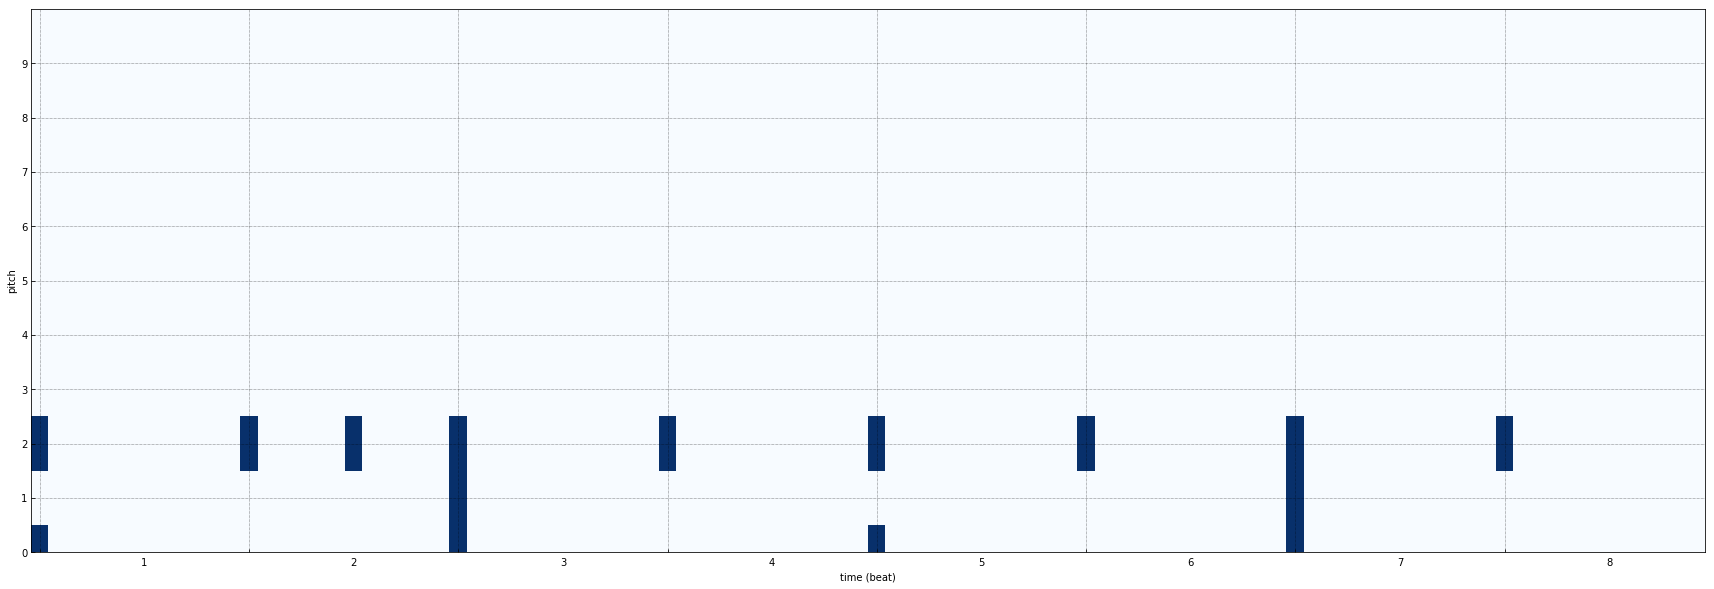

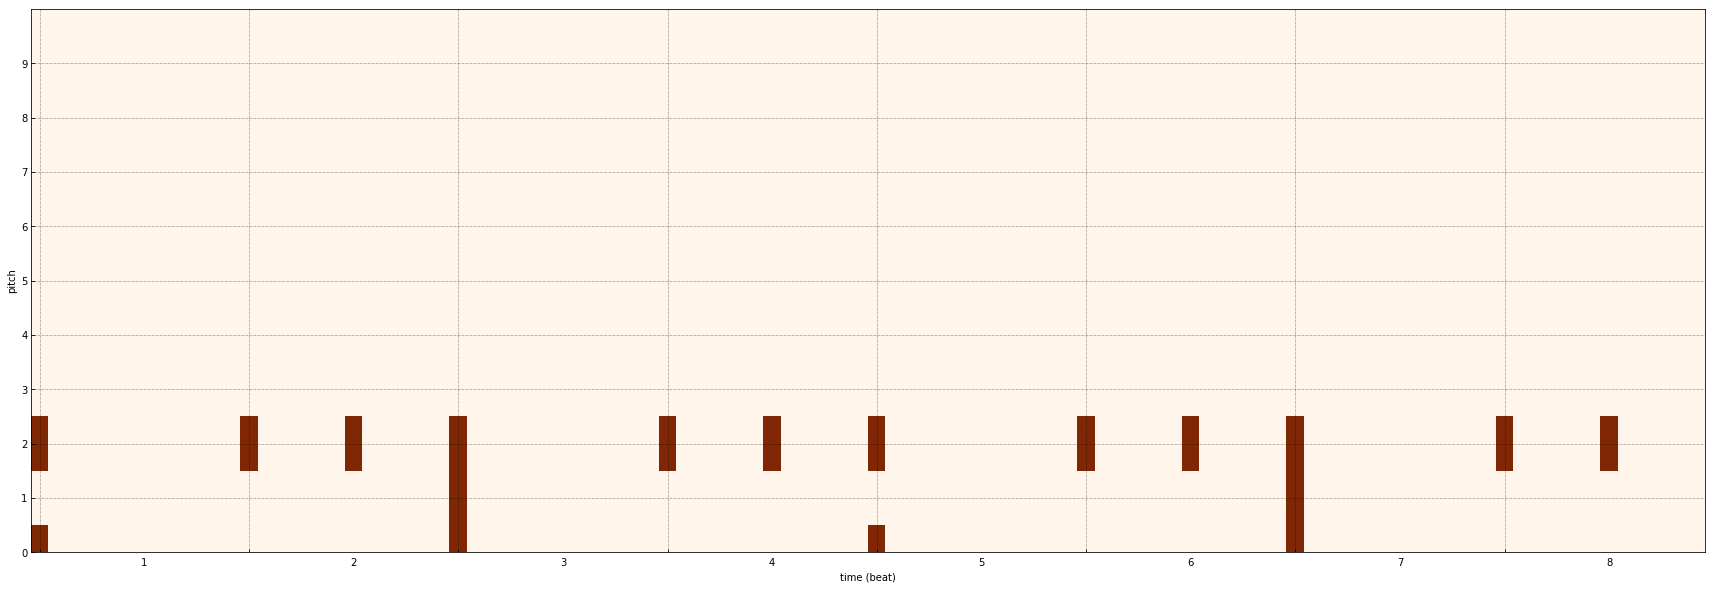

0.3229722 1.0166002e-08


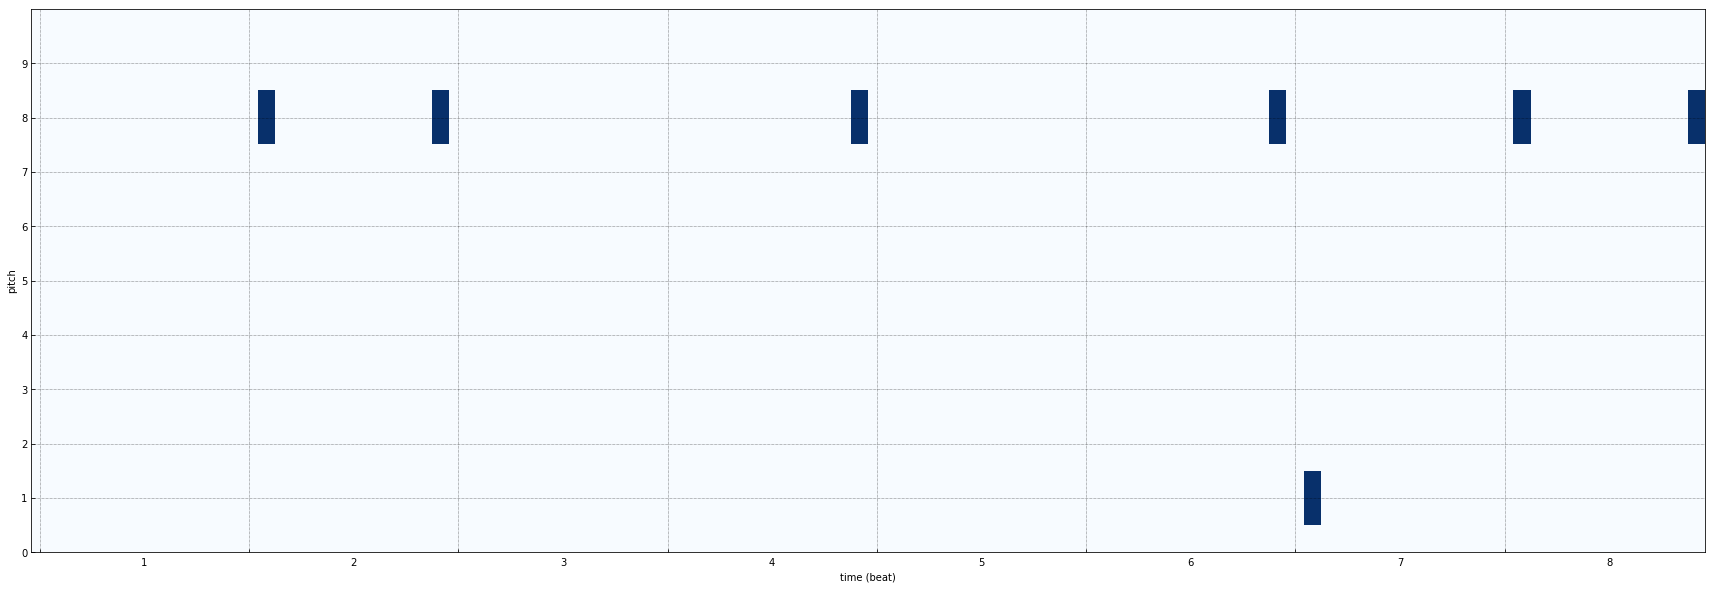

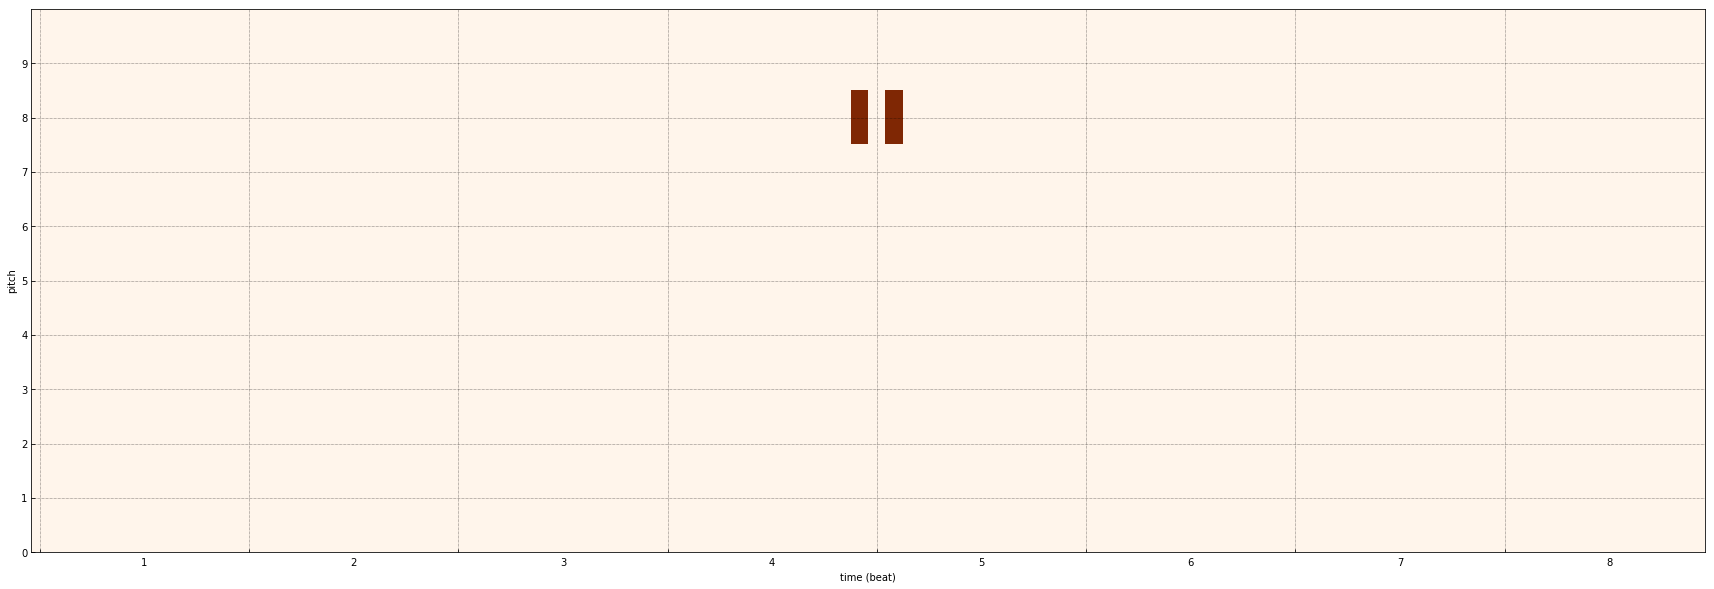

0.7615853 6.957106e-12


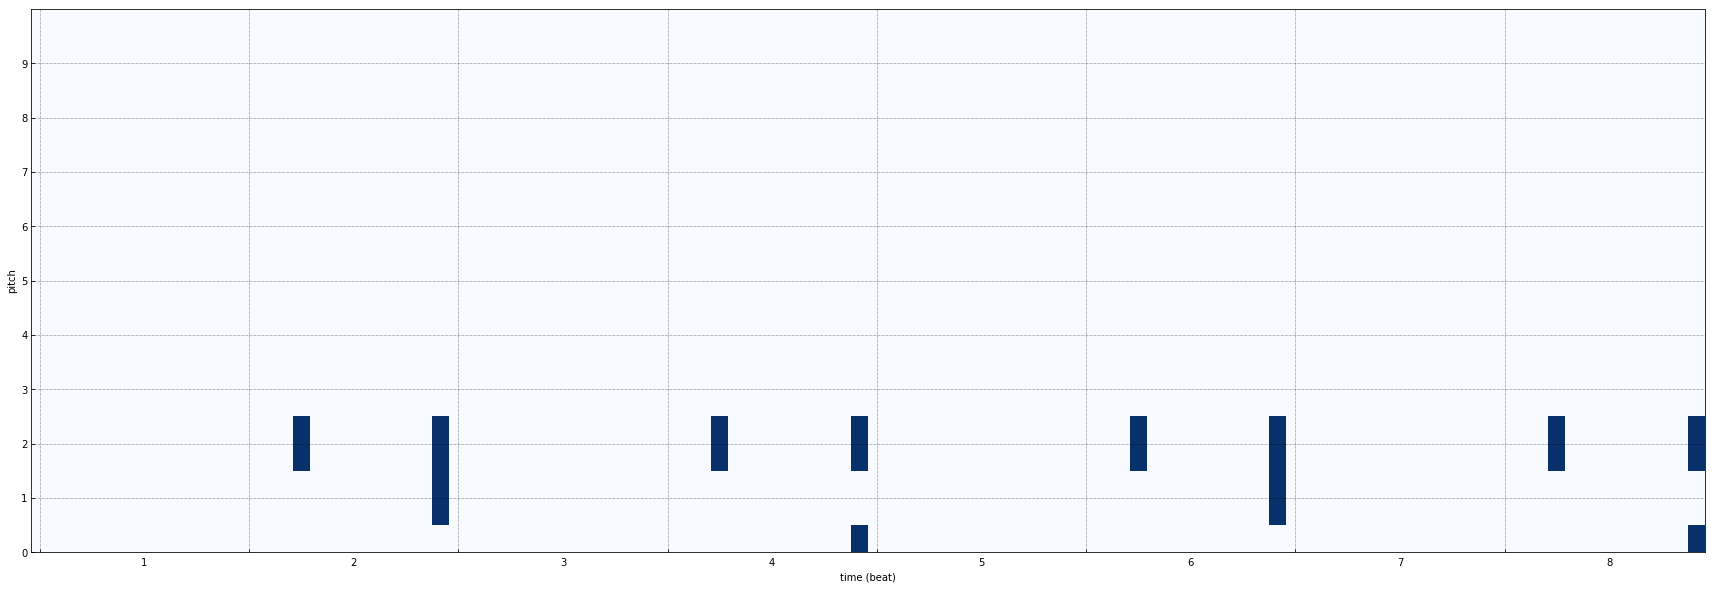

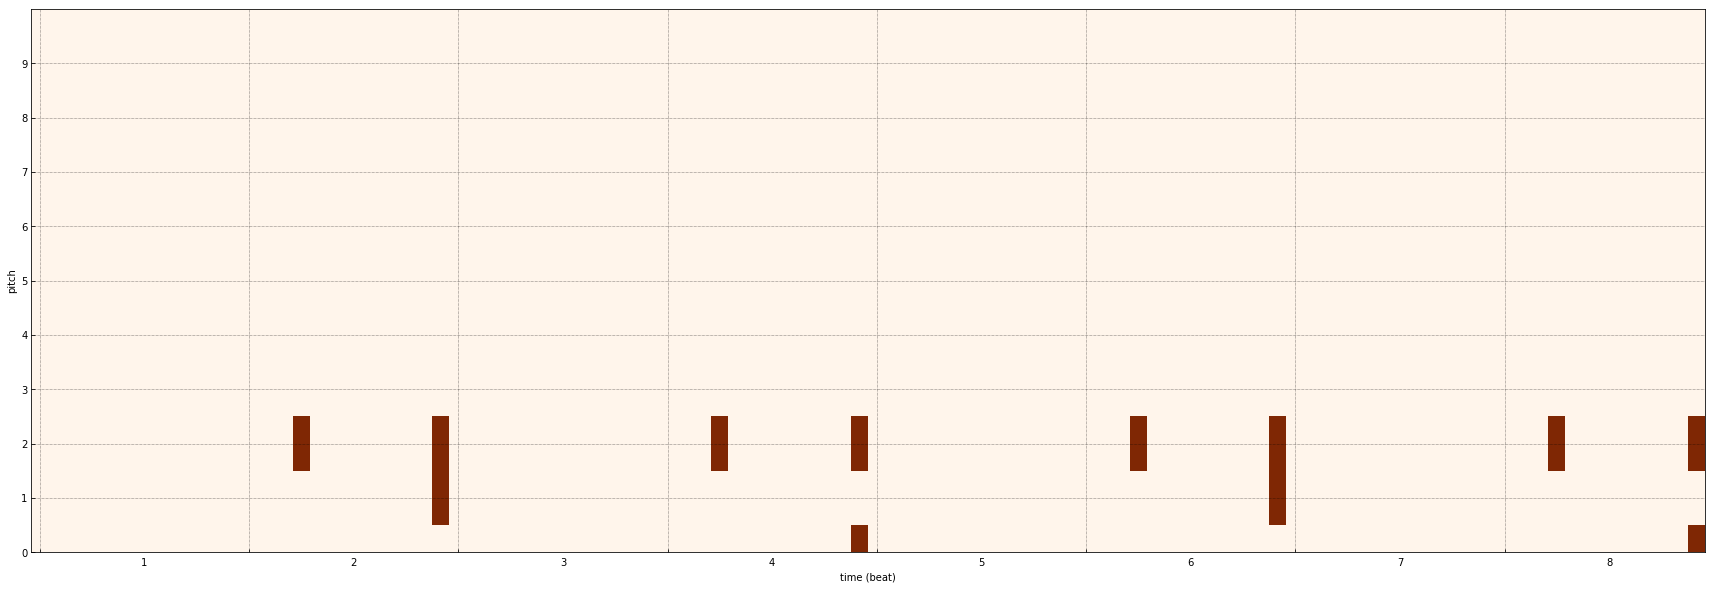

0.7613441 1.0846182e-08


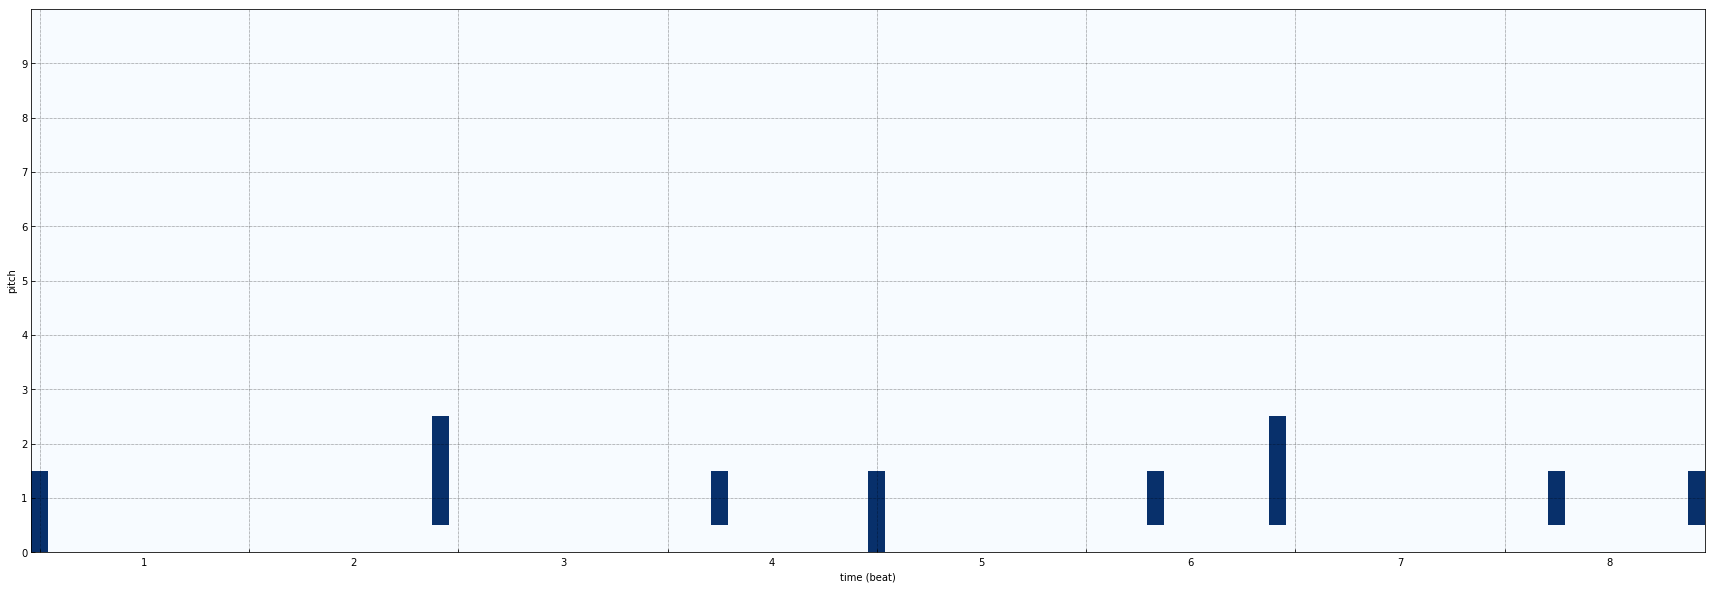

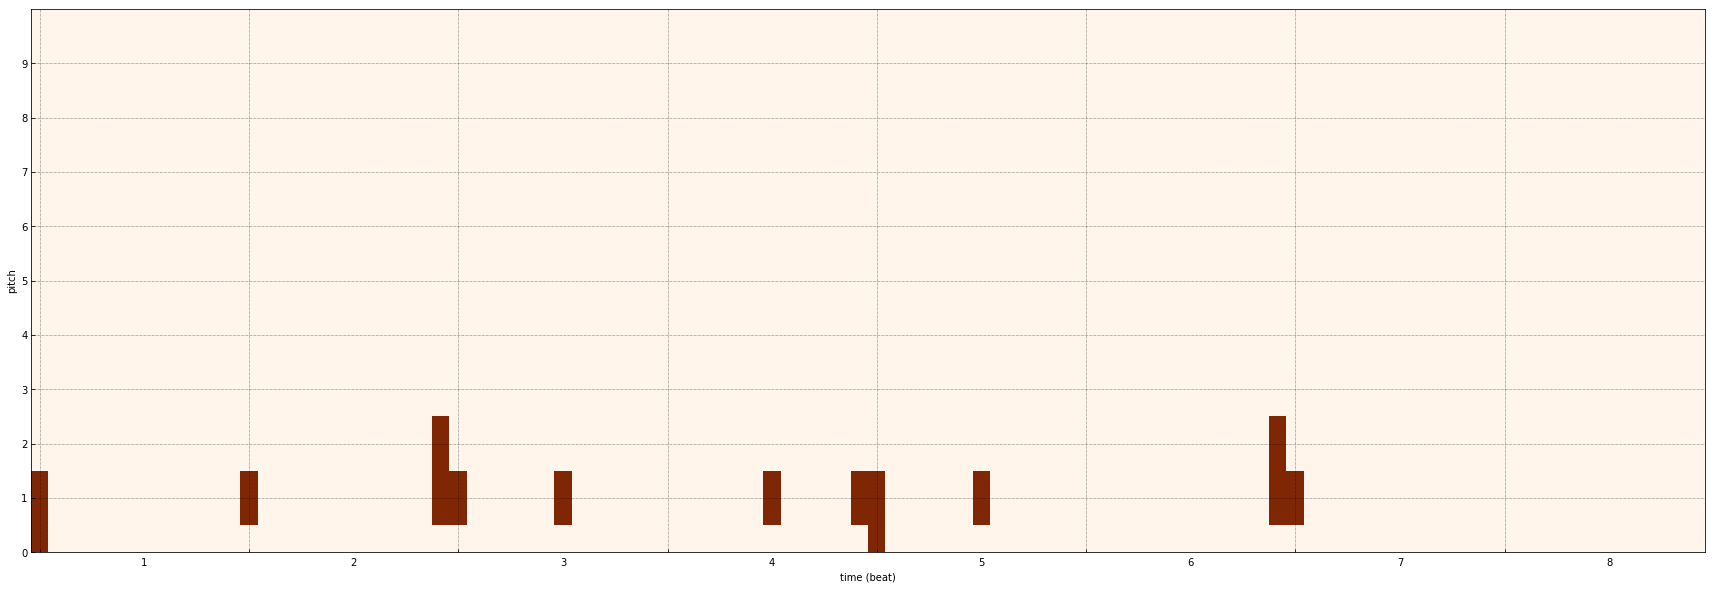

0.76155496 8.939681e-12


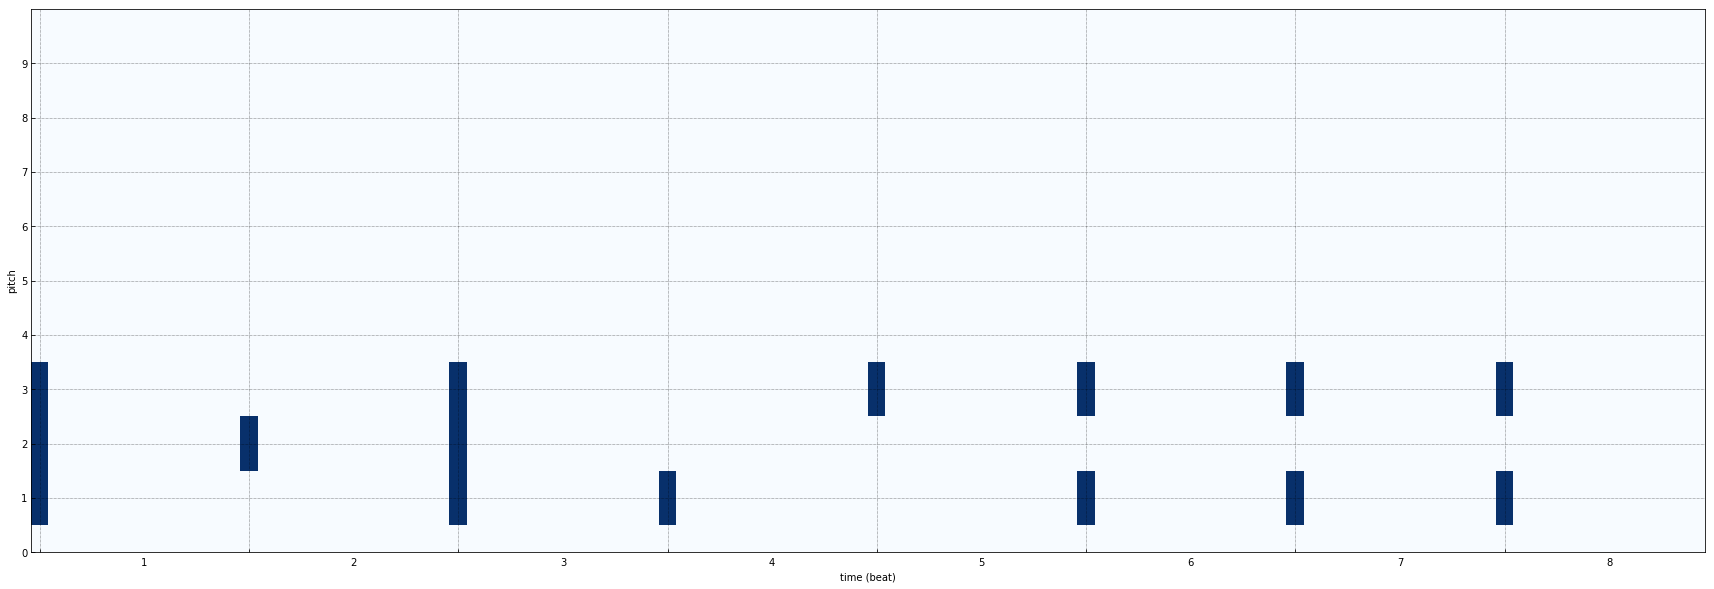

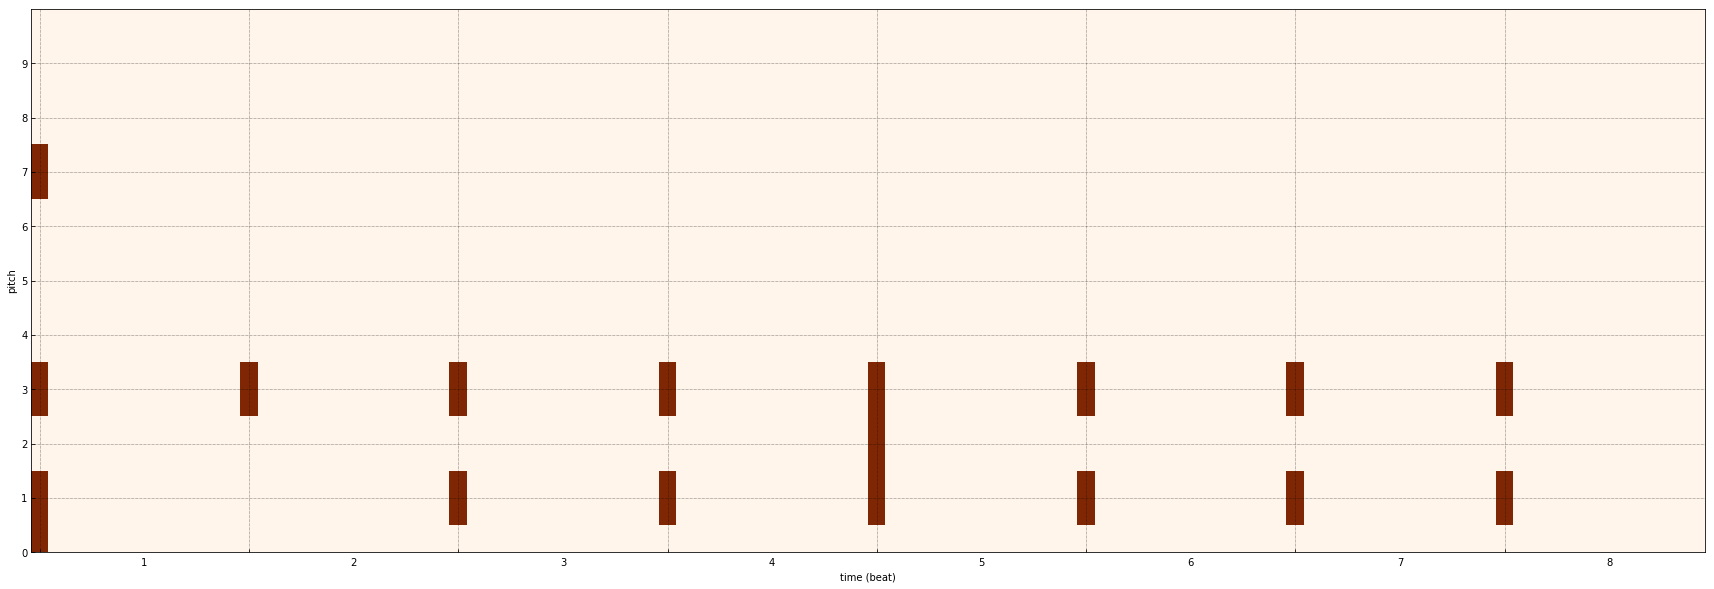

0.75723946 2.655431e-10


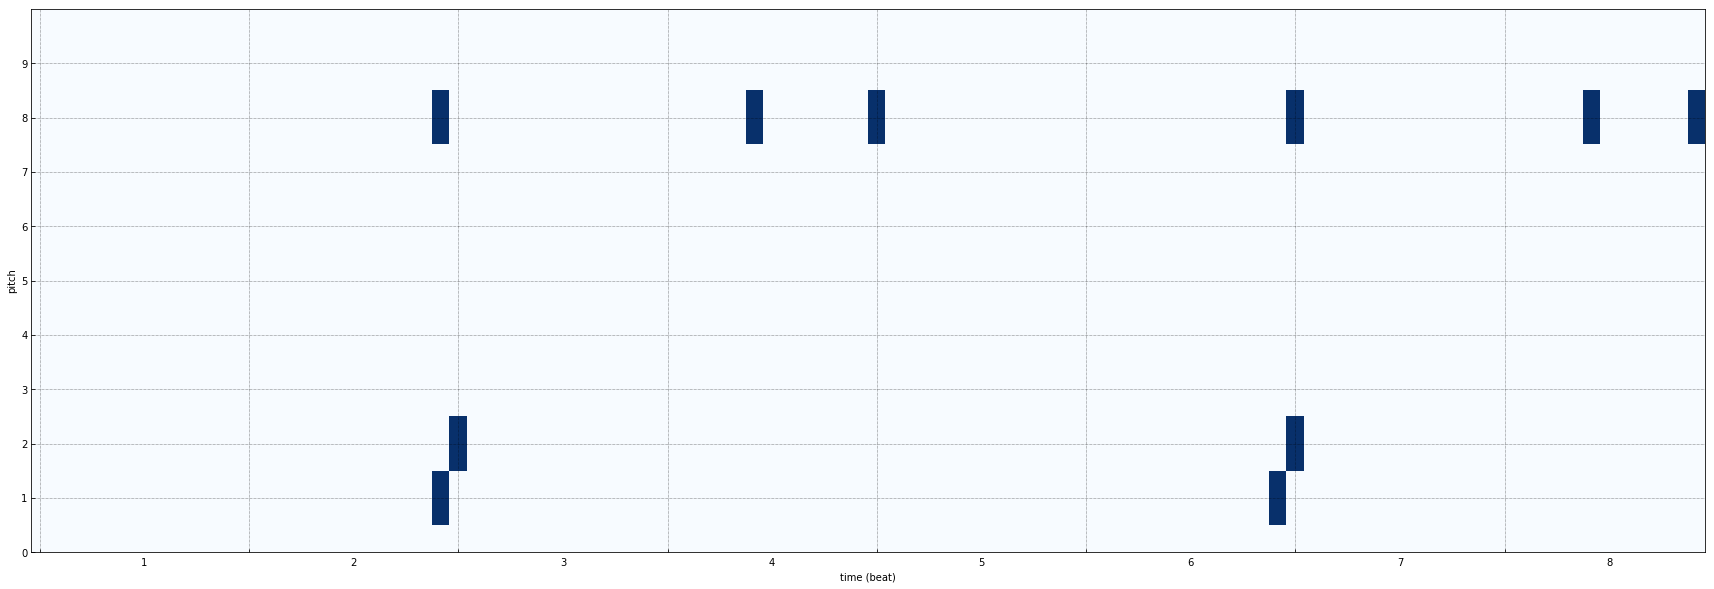

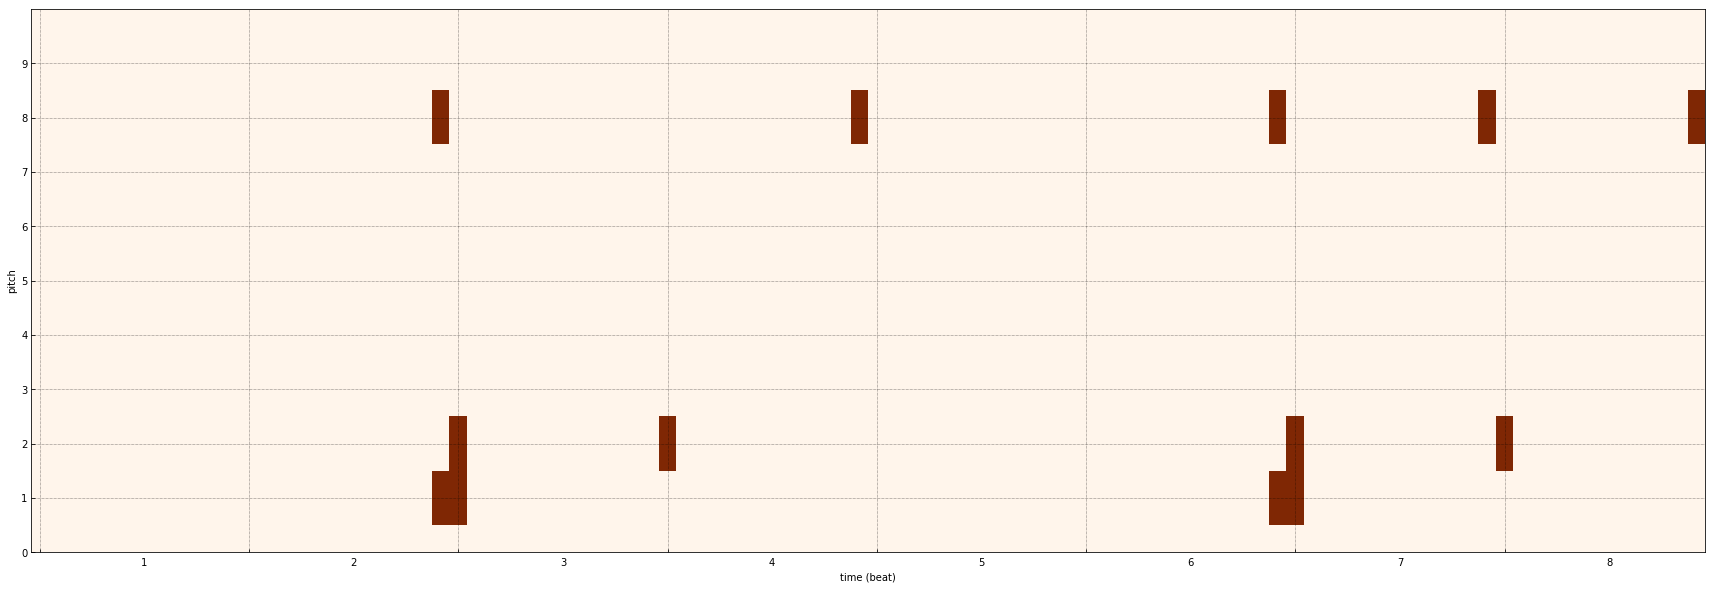

0.7594342 2.0171736e-13


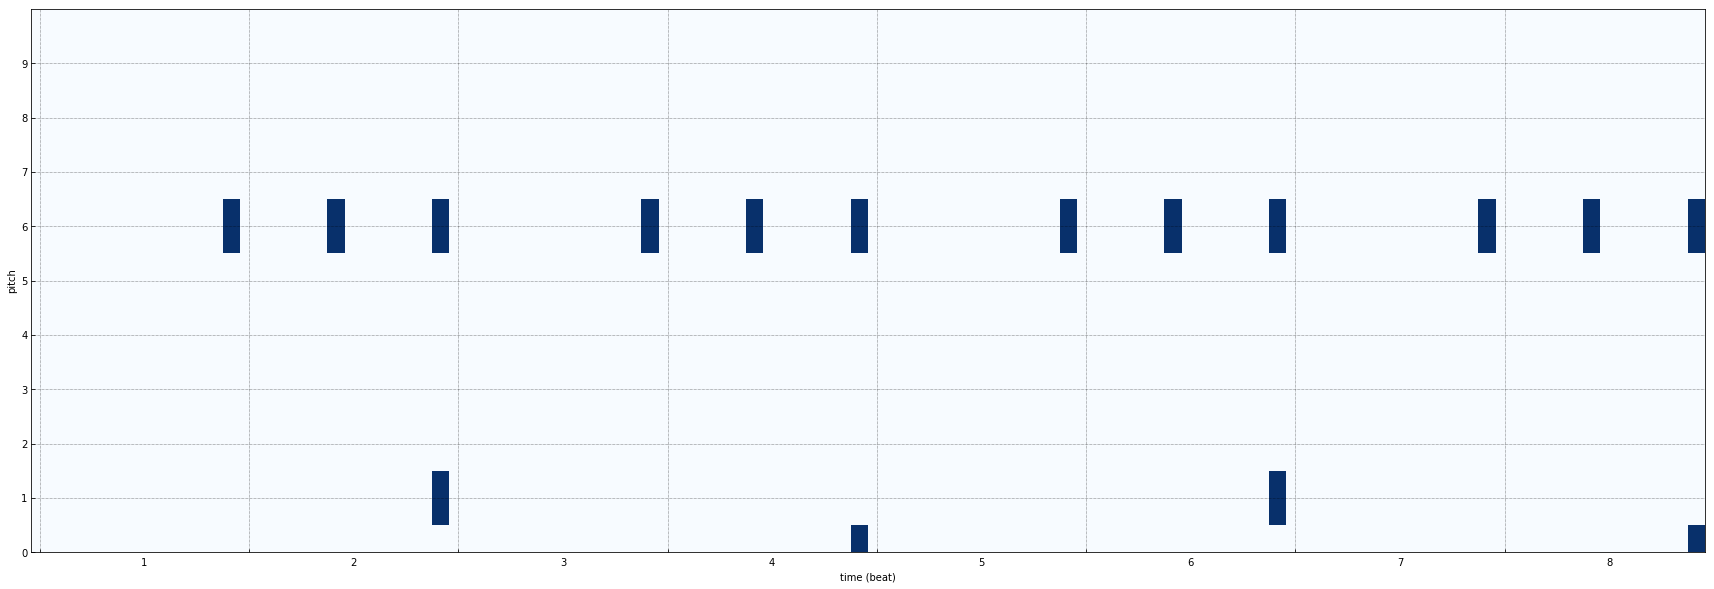

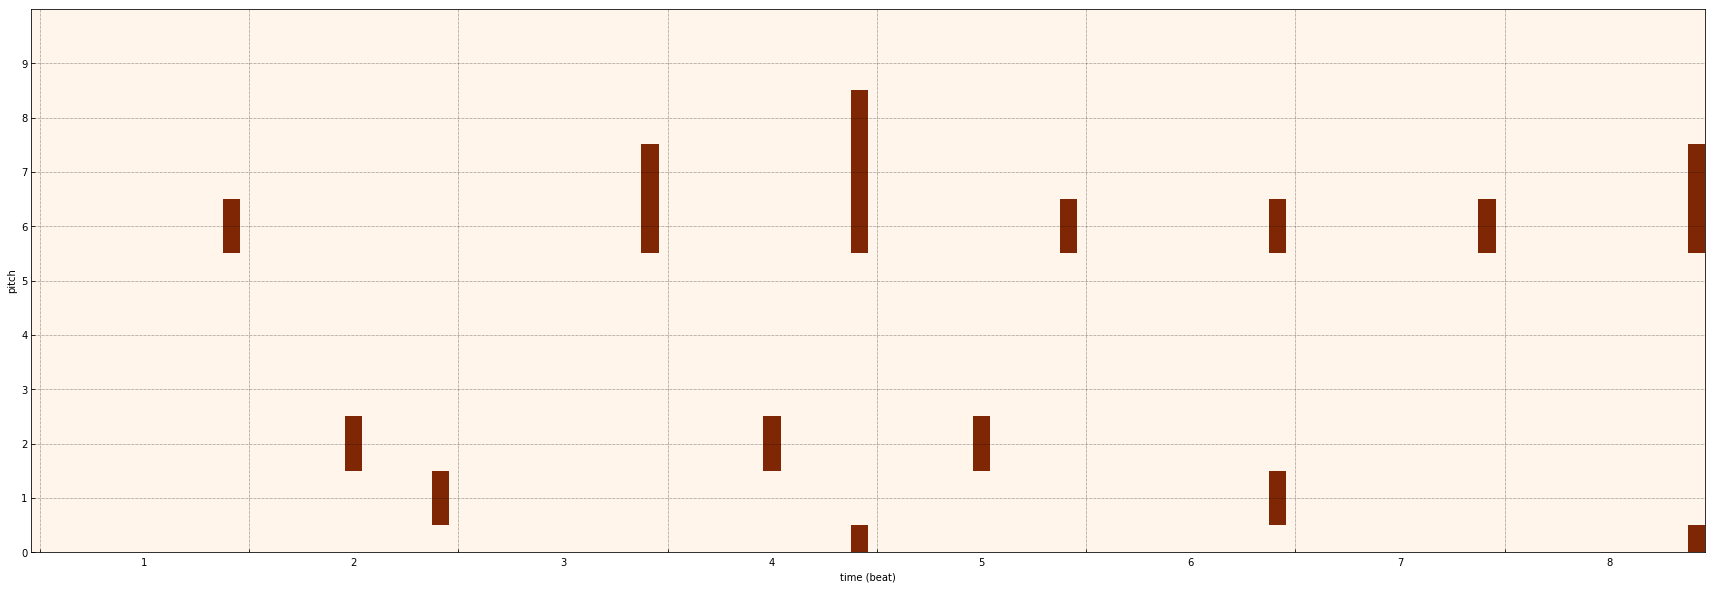

0.7600571 1.3246523e-09


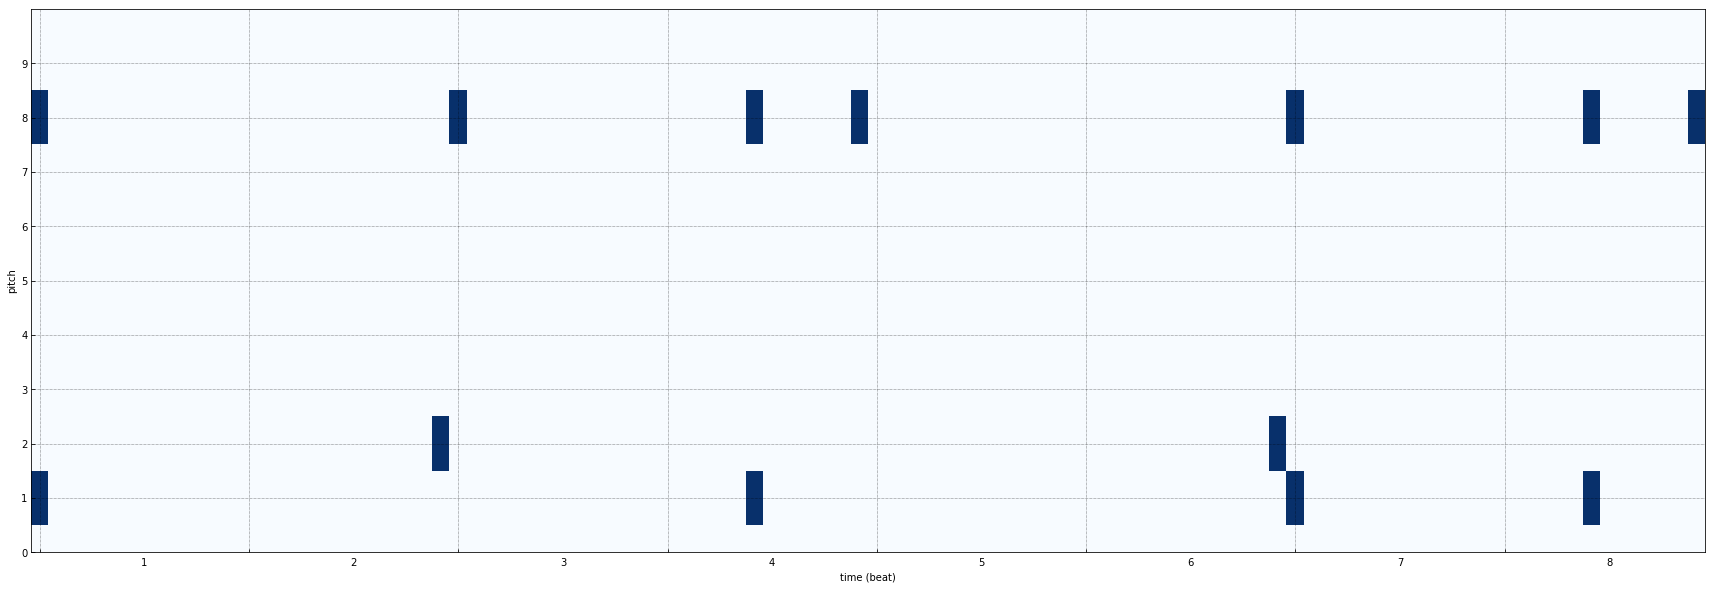

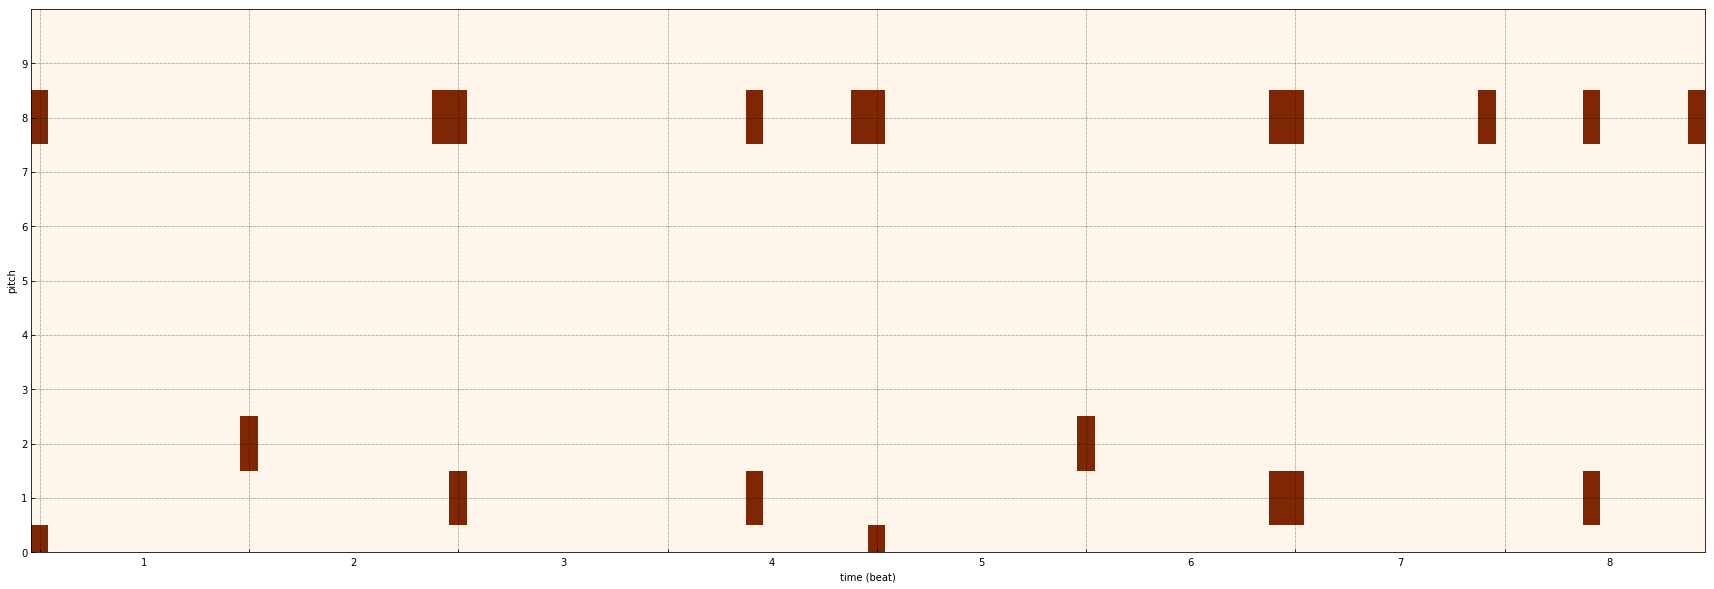

0.761529 4.6733914e-12


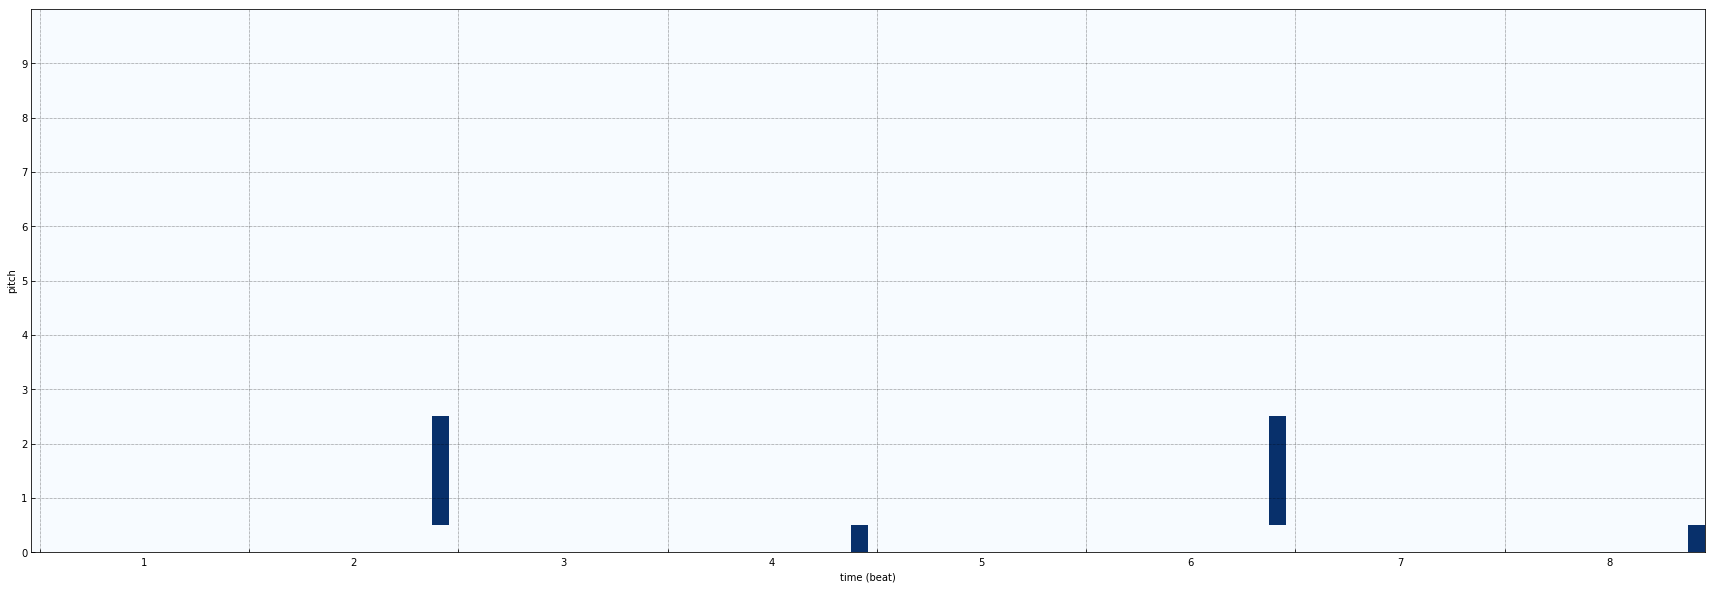

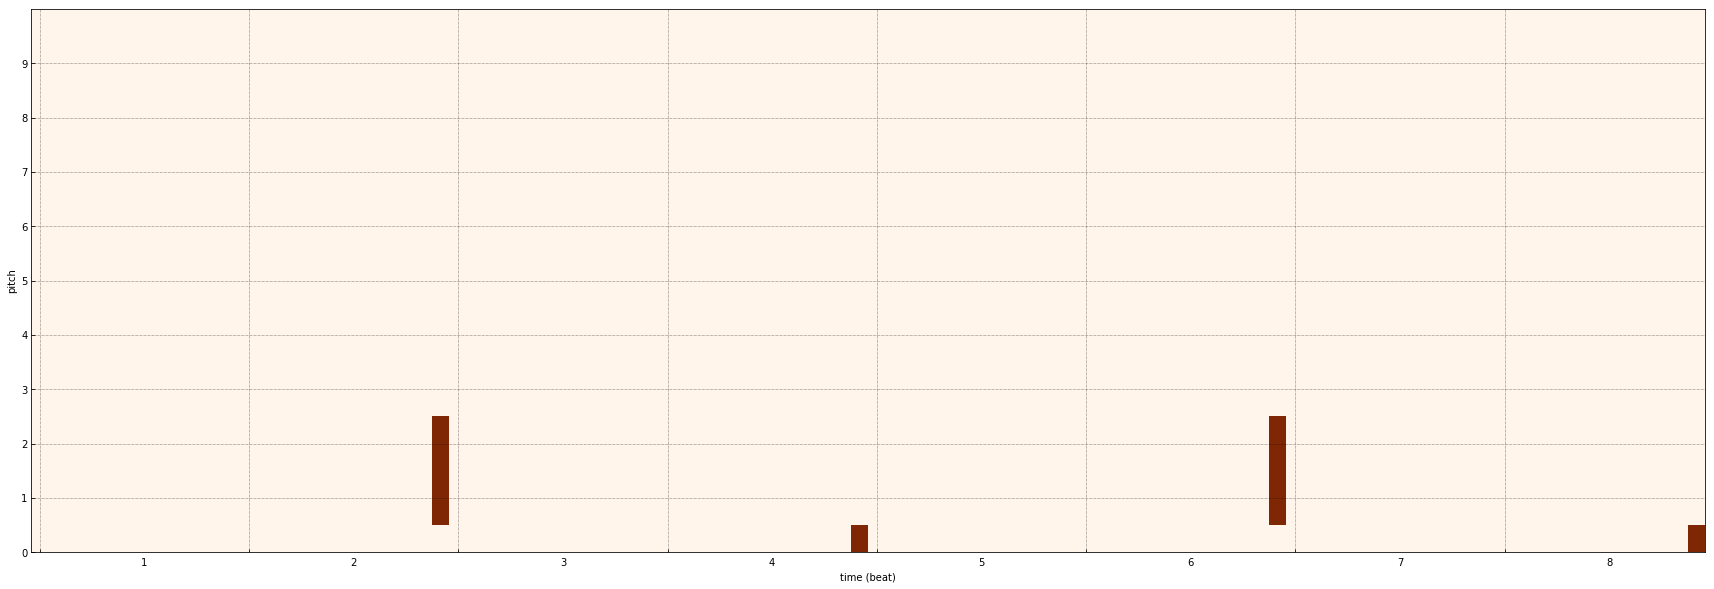

0.7615818 1.2283963e-11


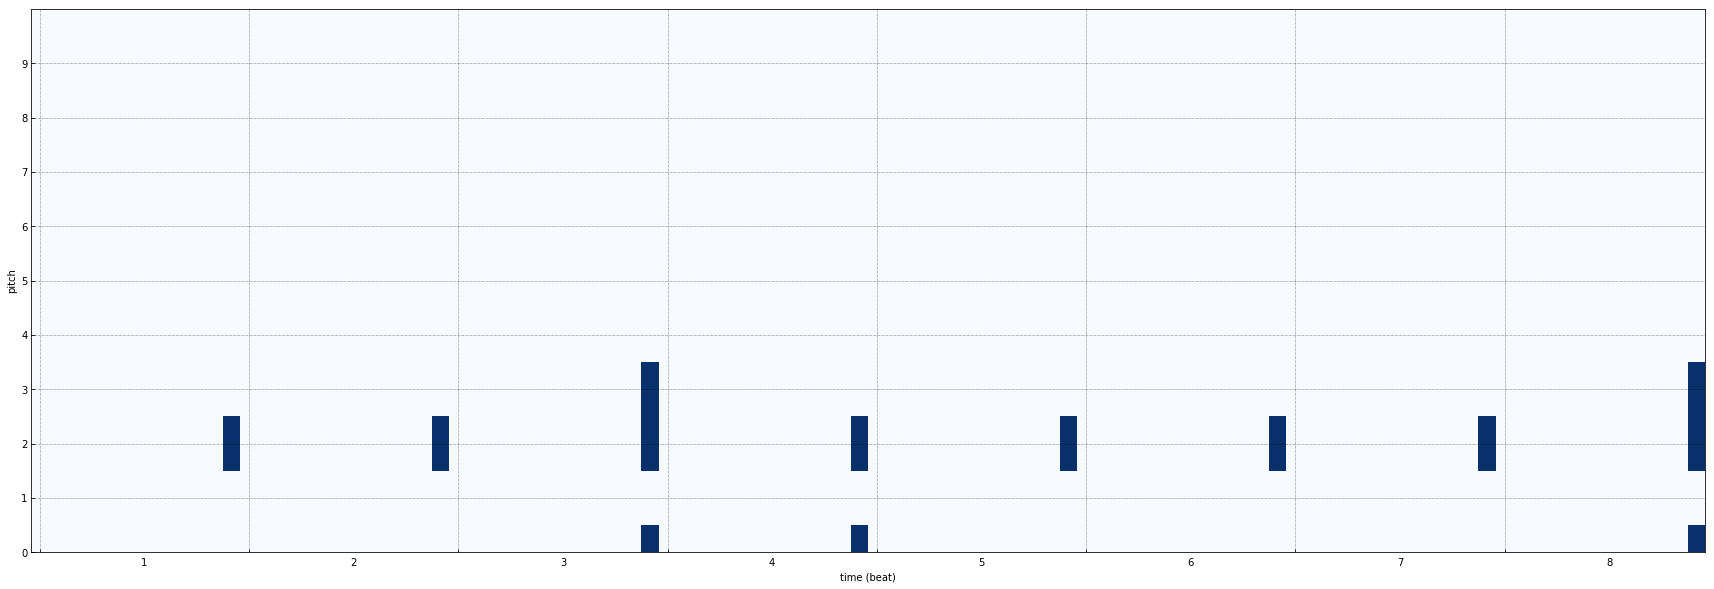

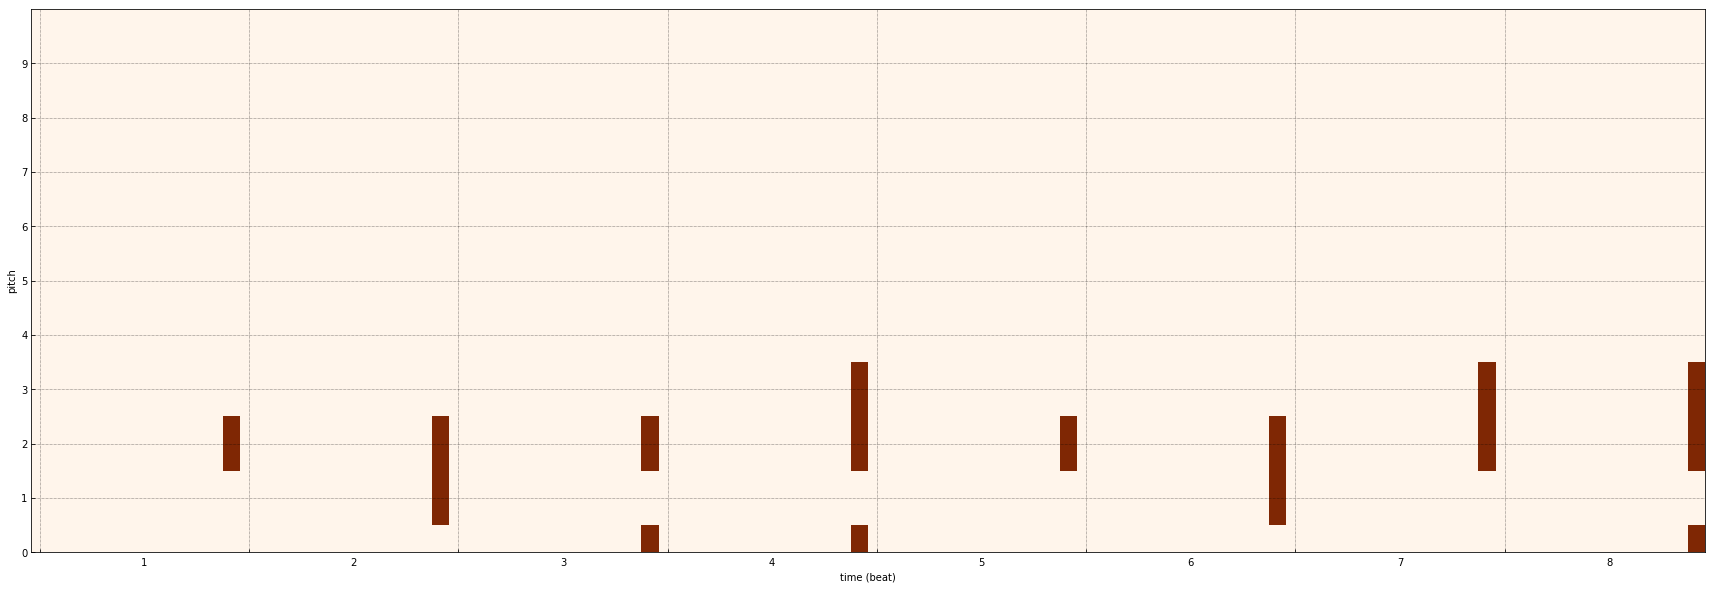

0.7615895 4.8718946e-11


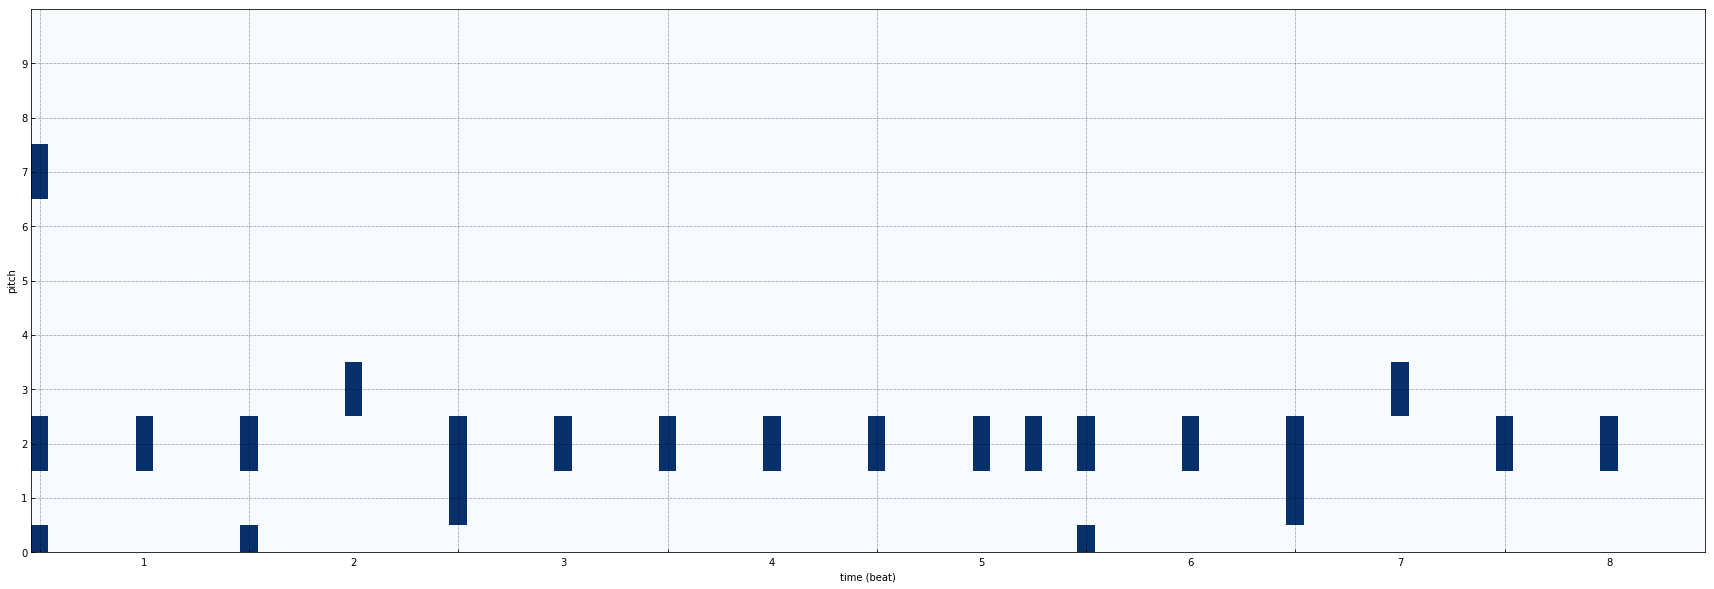

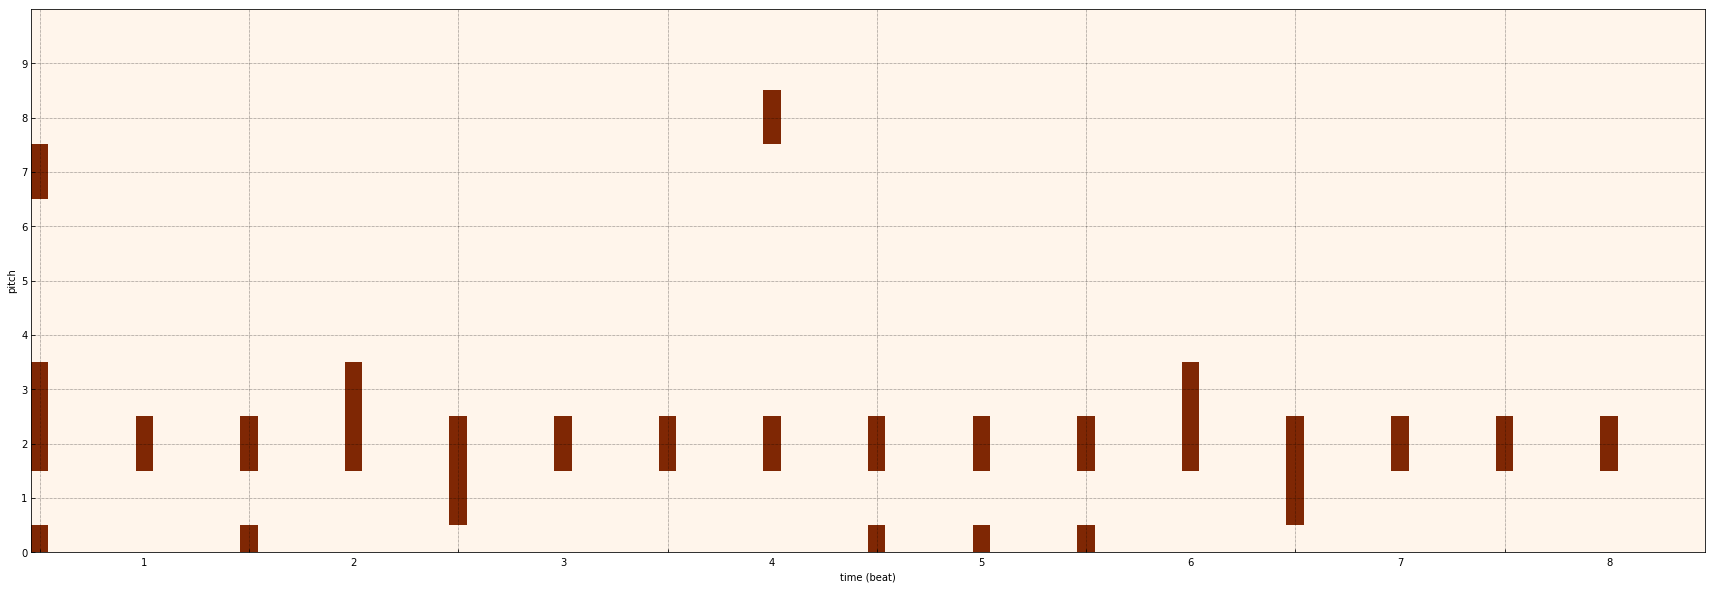

0.7615262 3.0110803e-11


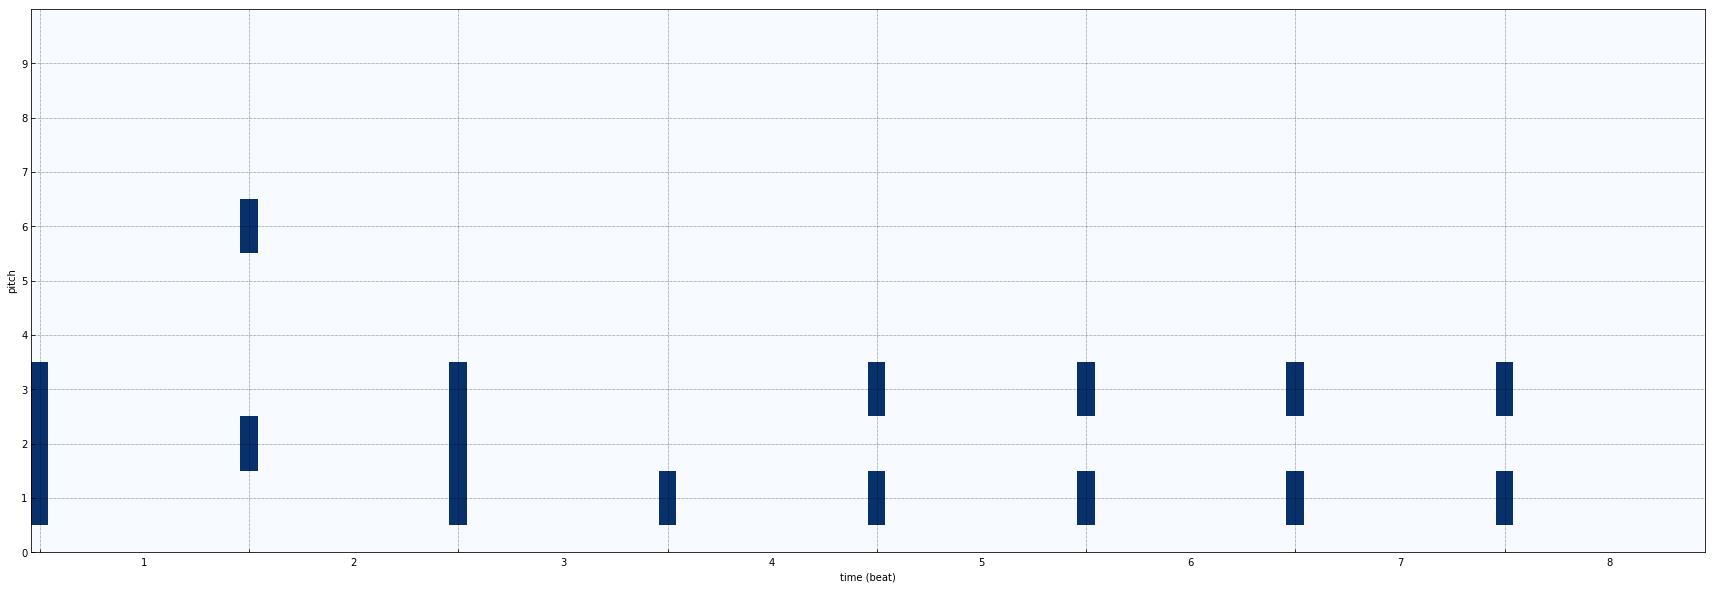

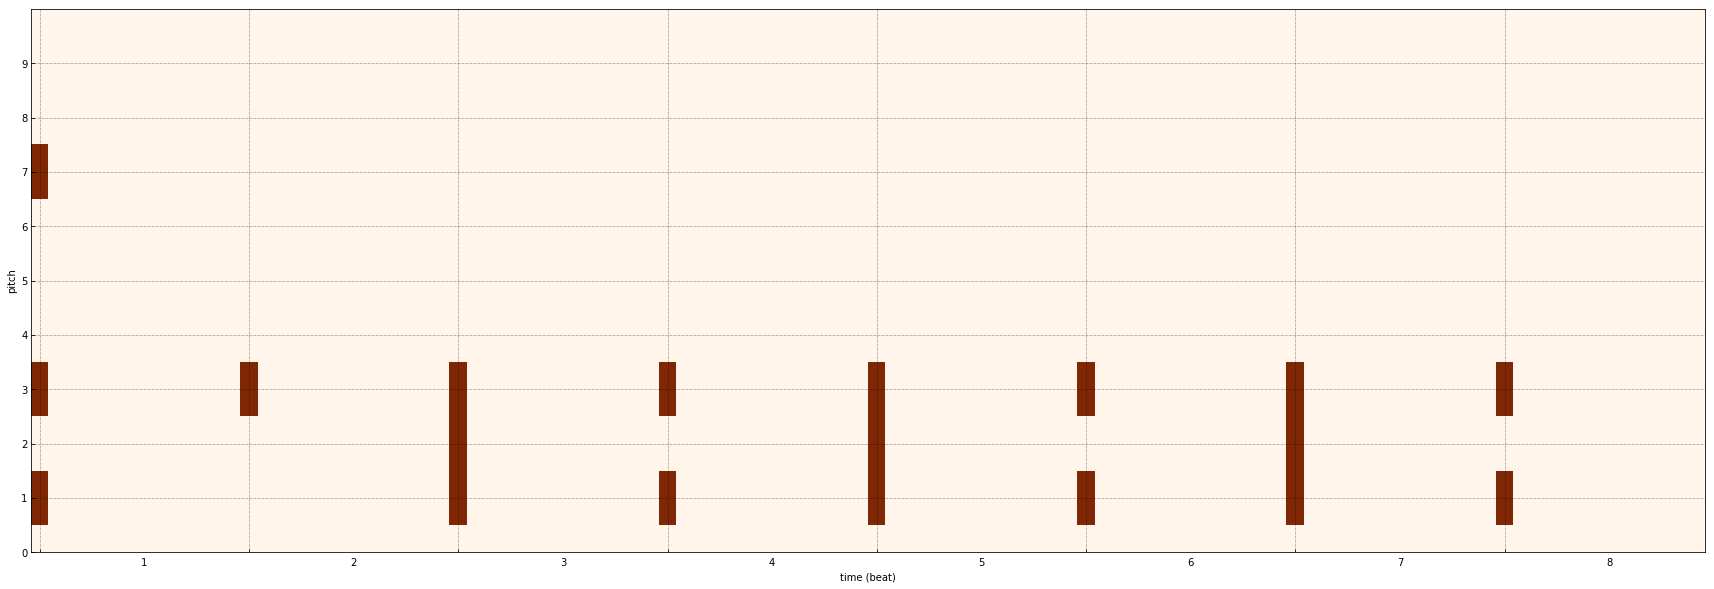

0.76149887 1.2236879e-09


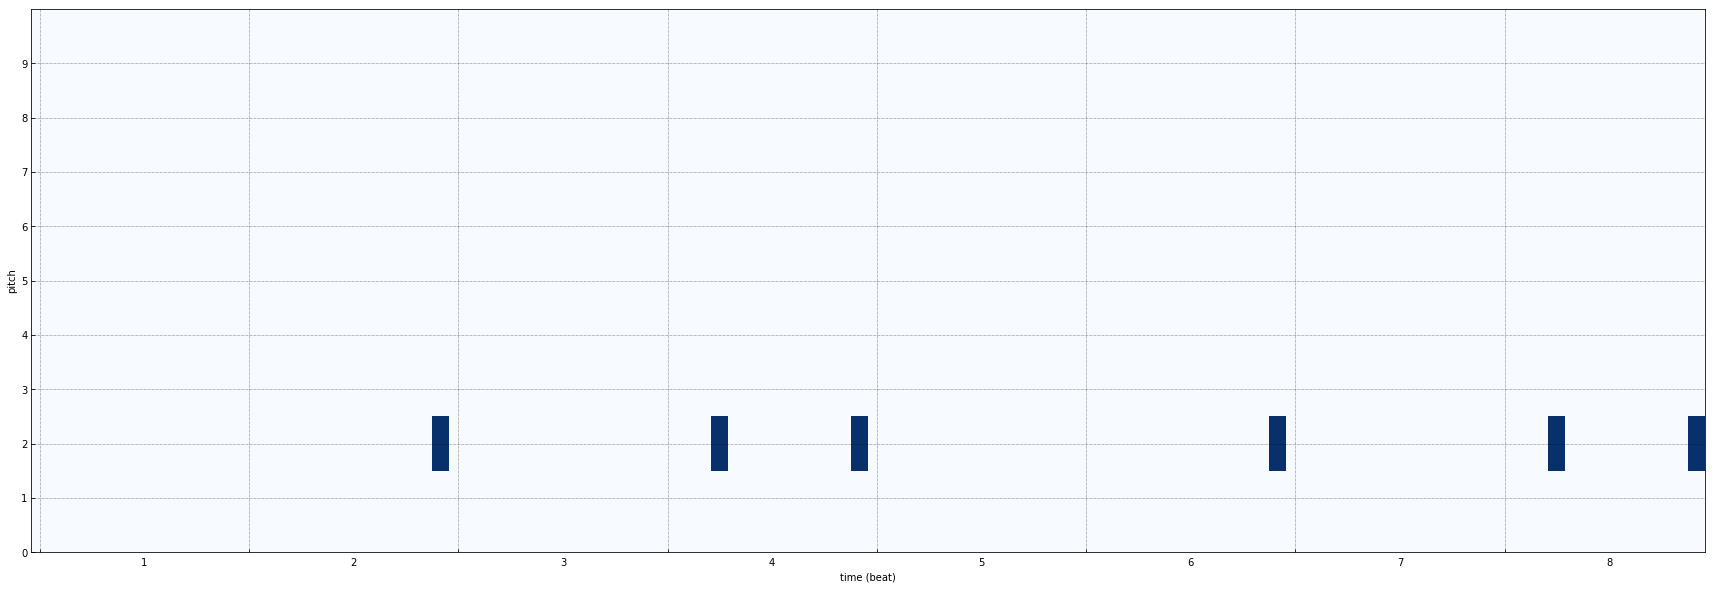

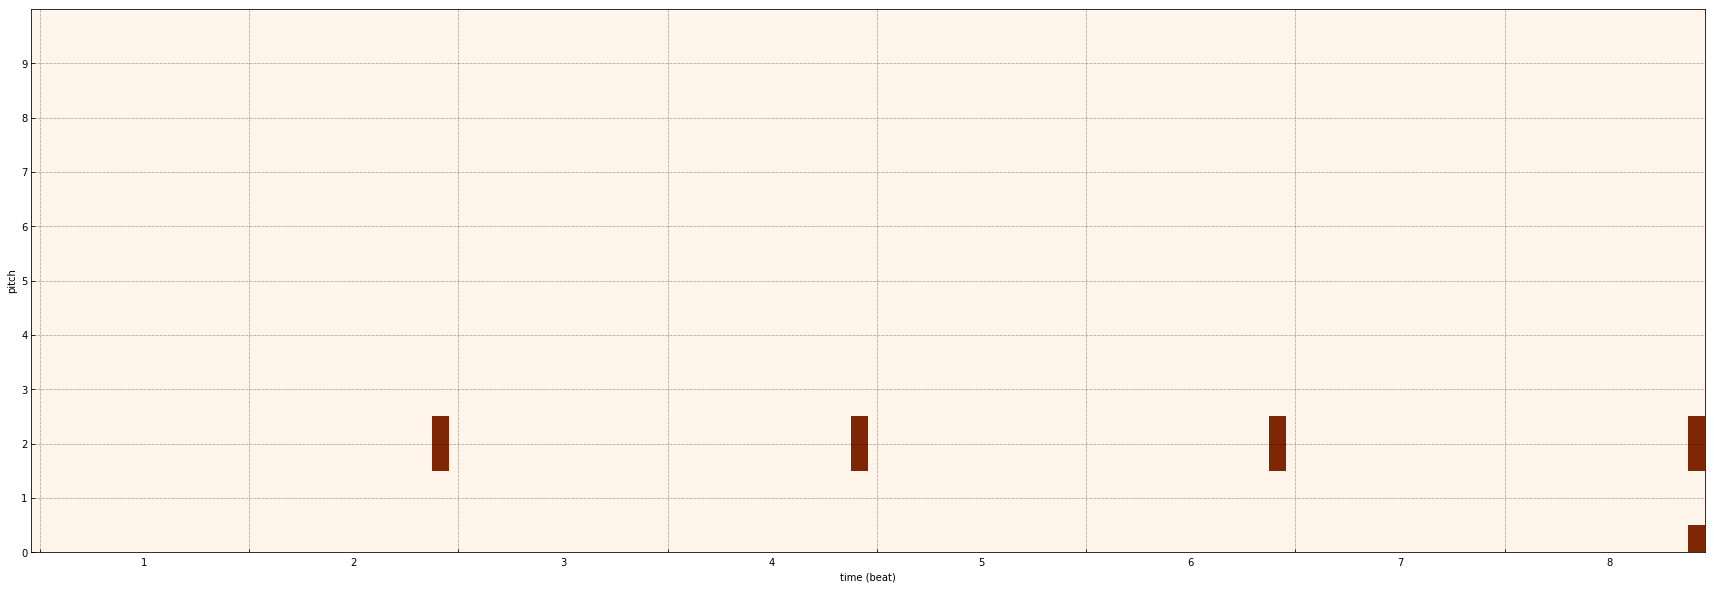

0.7612817 5.668094e-09


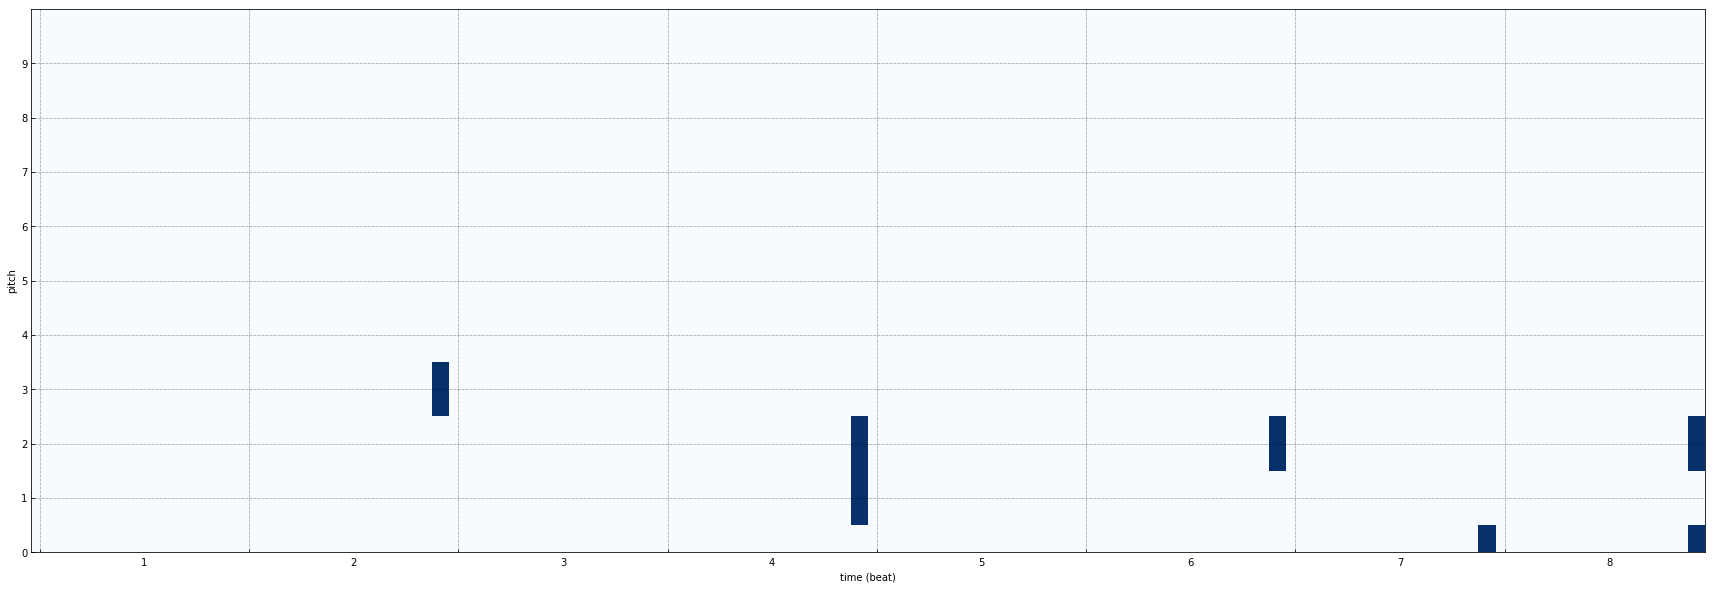

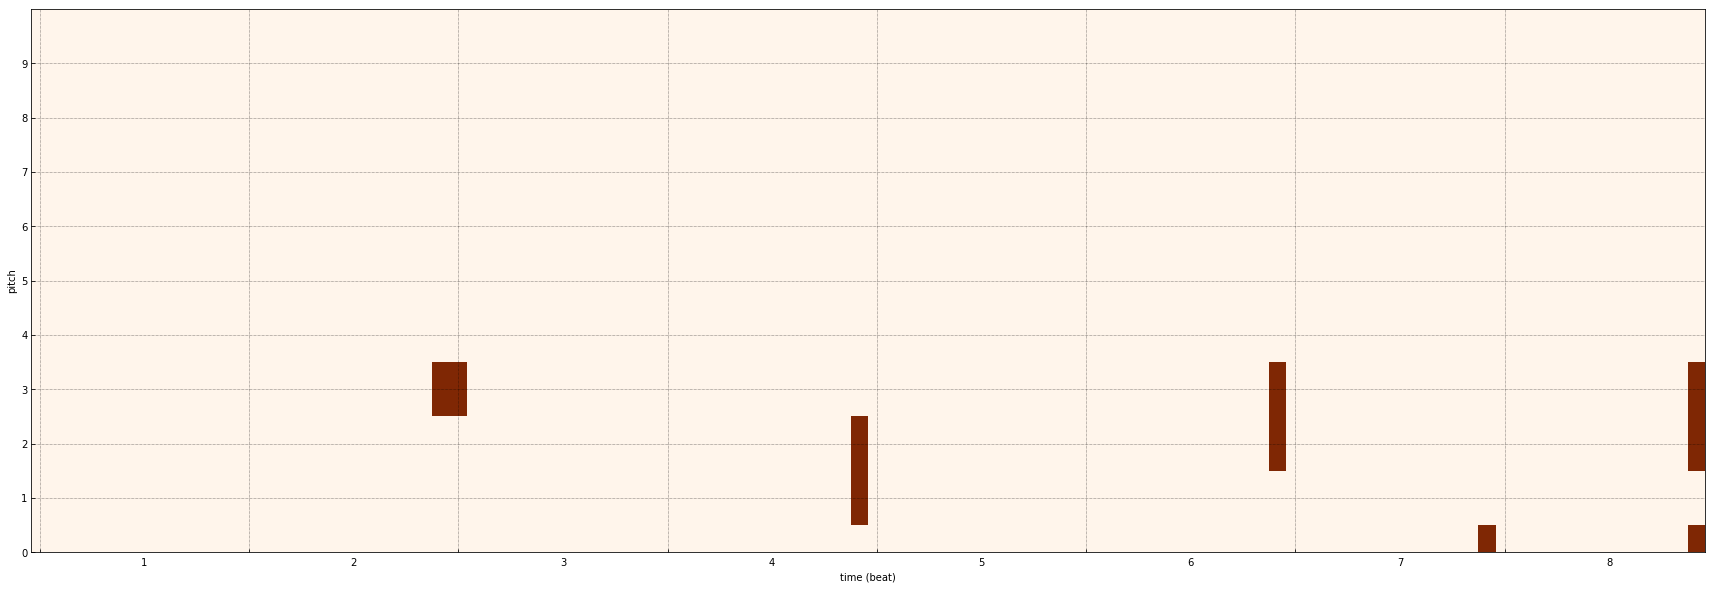

0.76140225 1.796759e-09


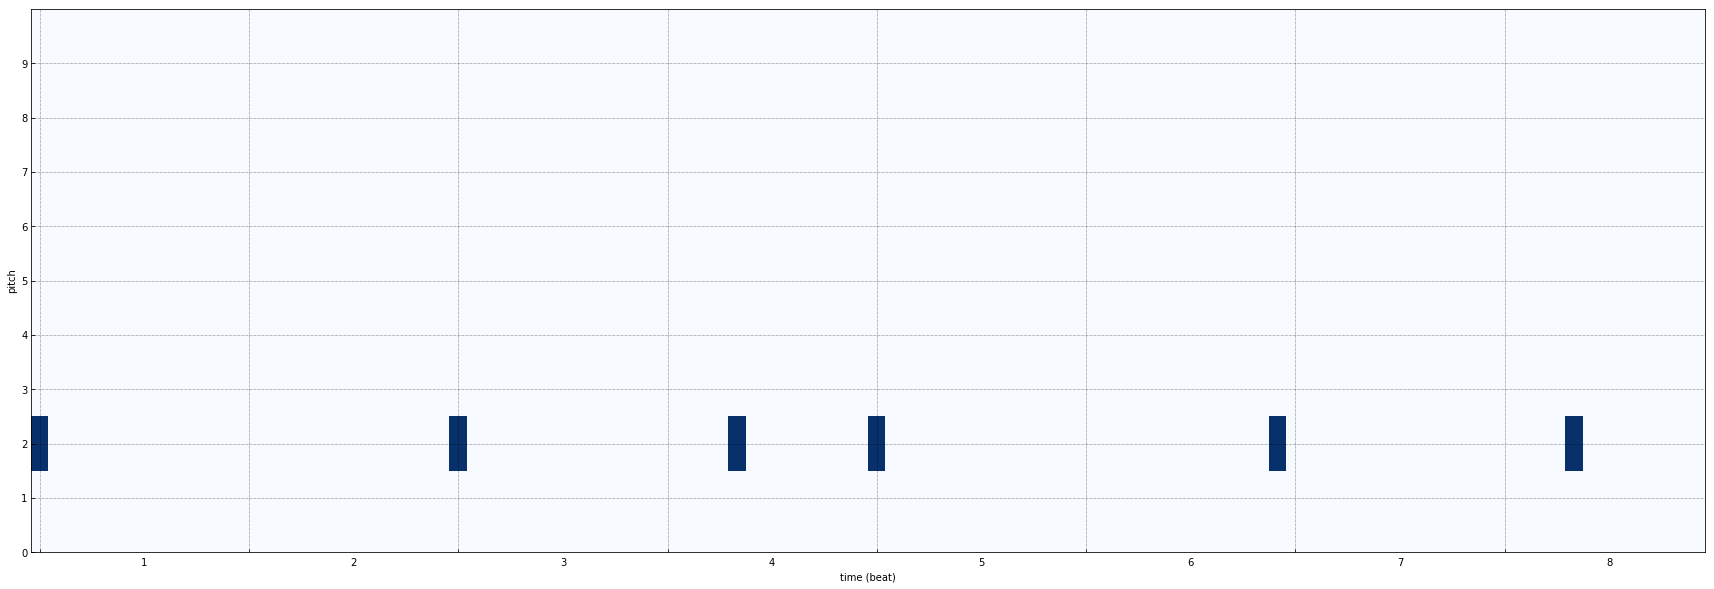

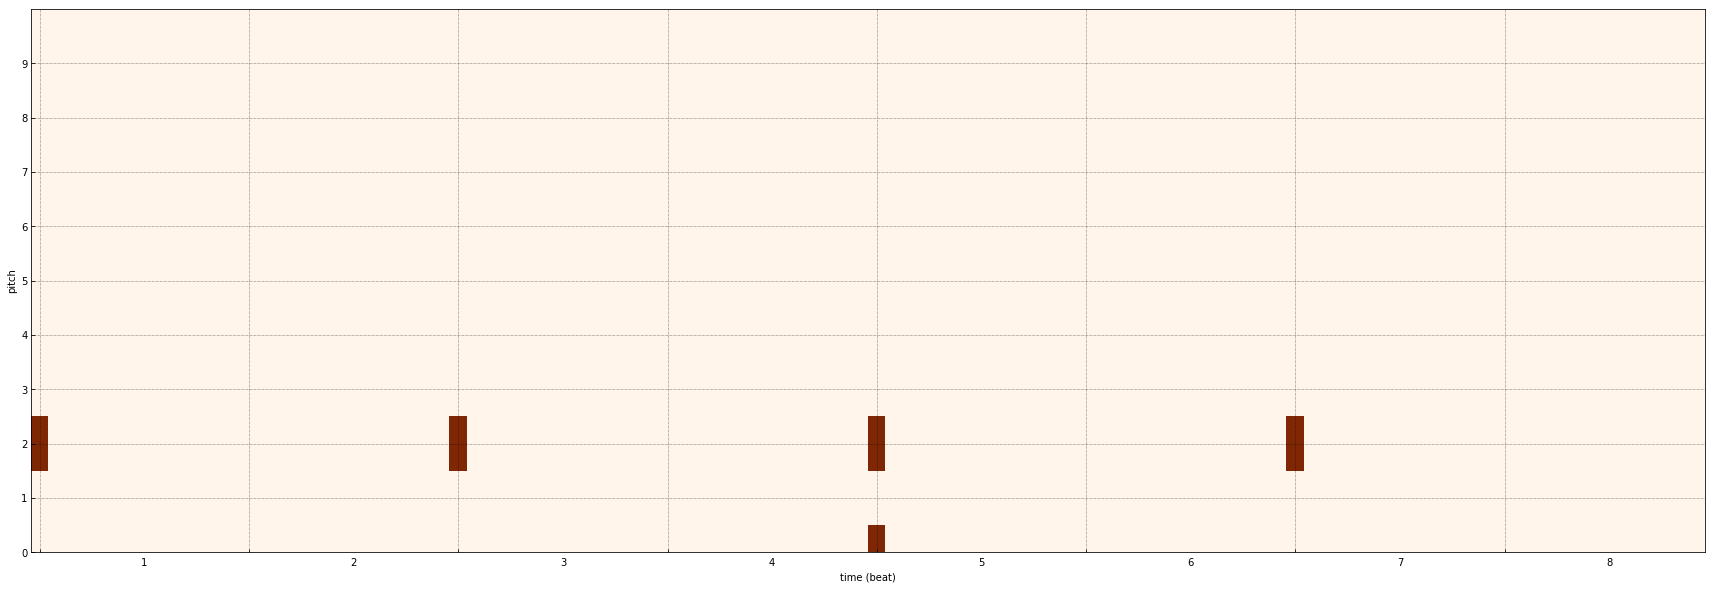

0.7610506 9.475294e-11


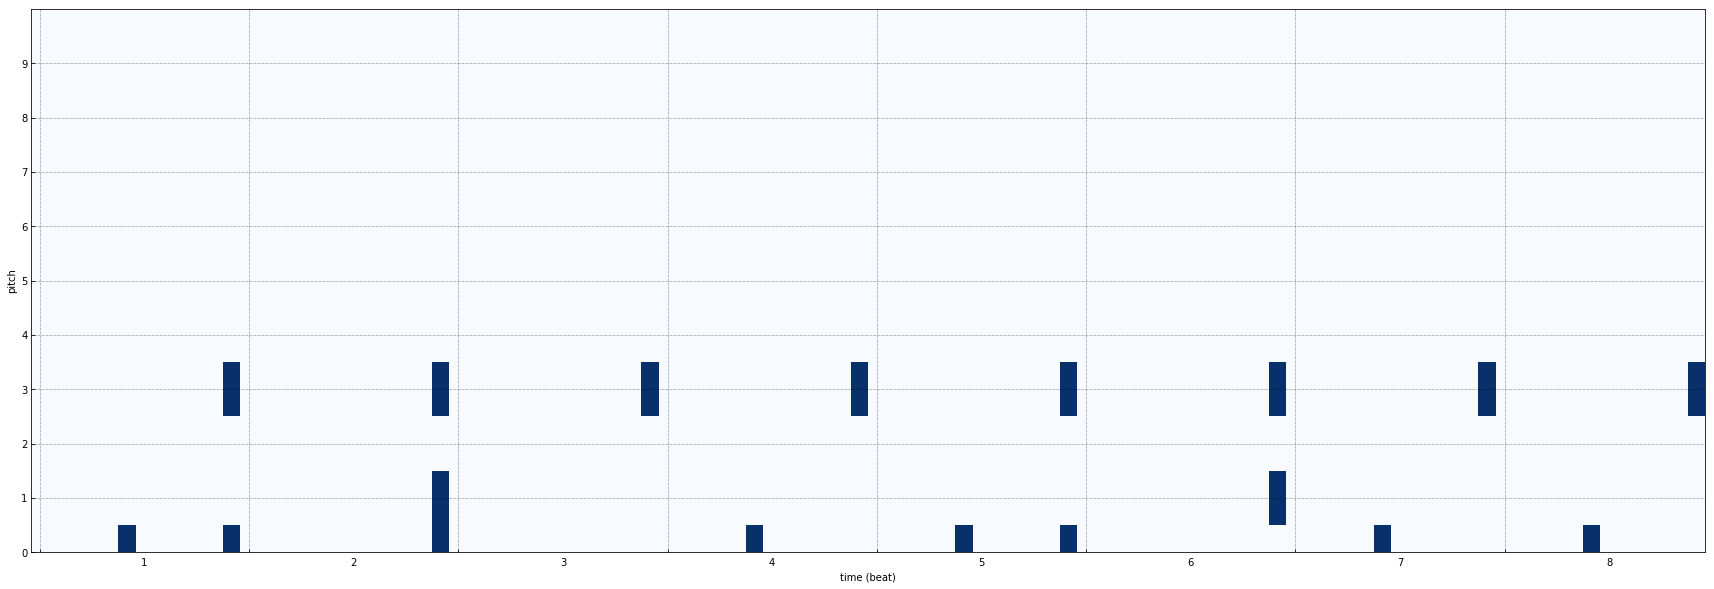

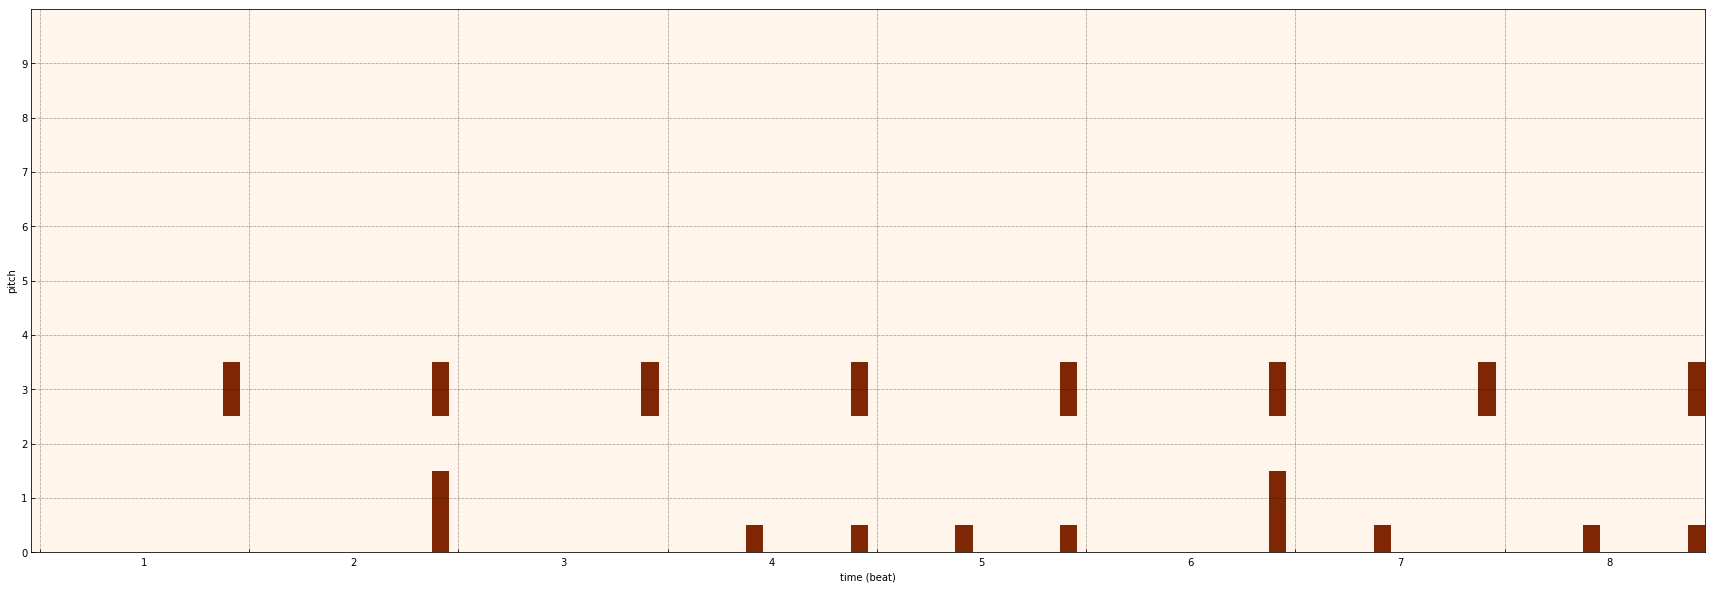

0.76155686 4.4574552e-10


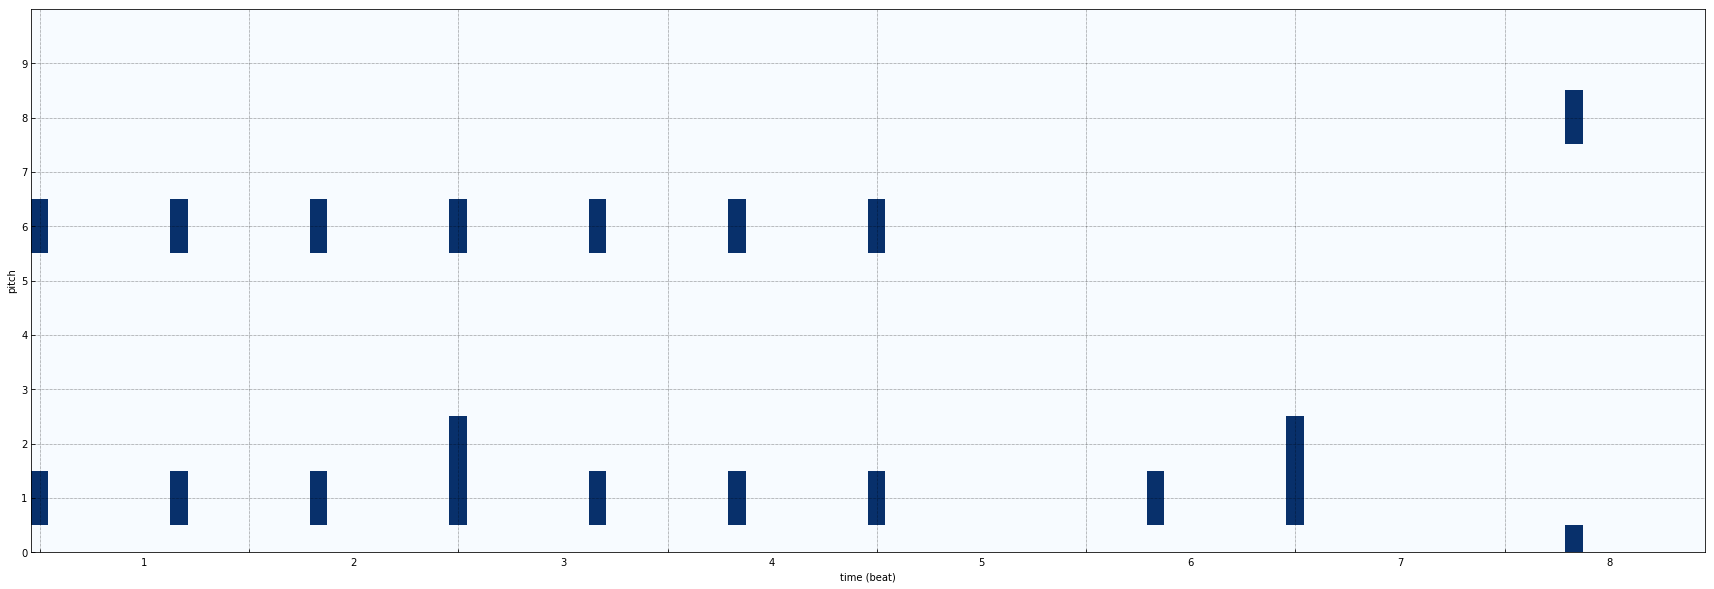

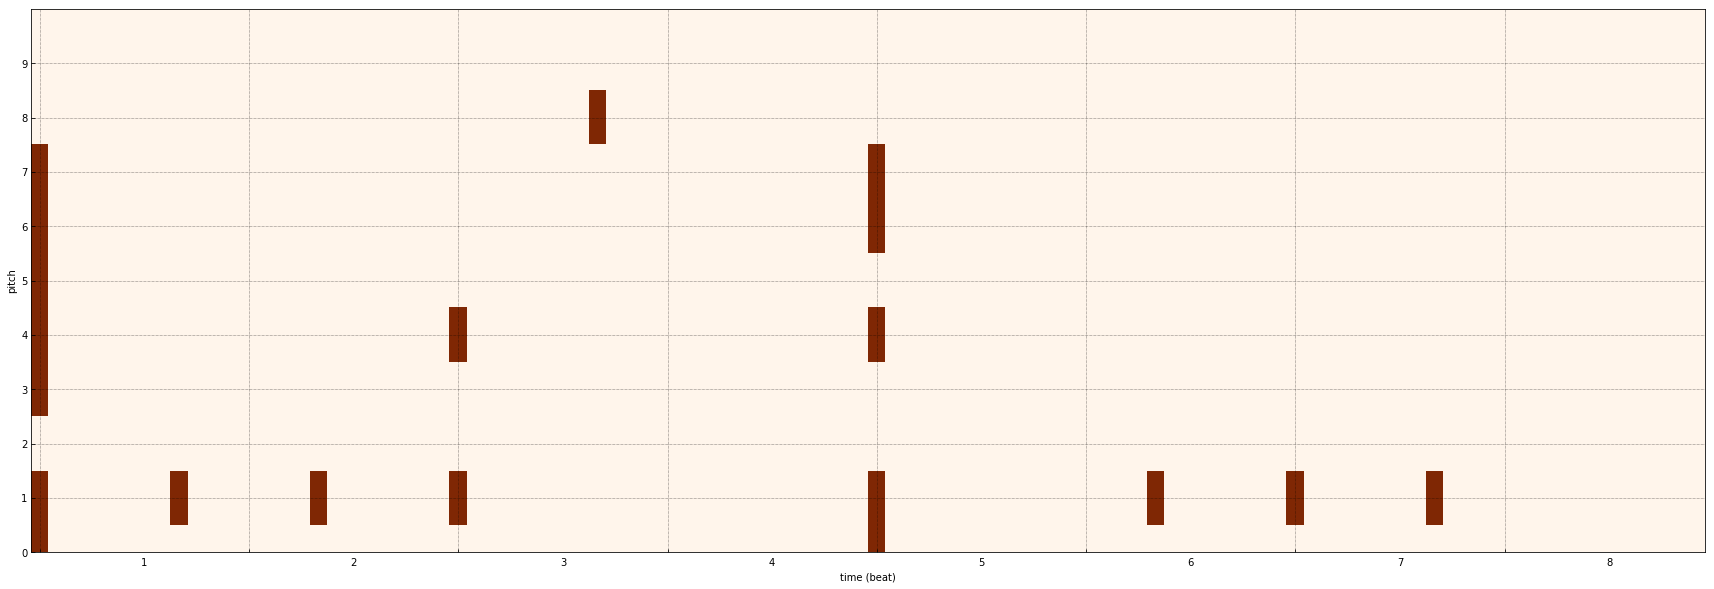

0.76156026 1.2133387e-09


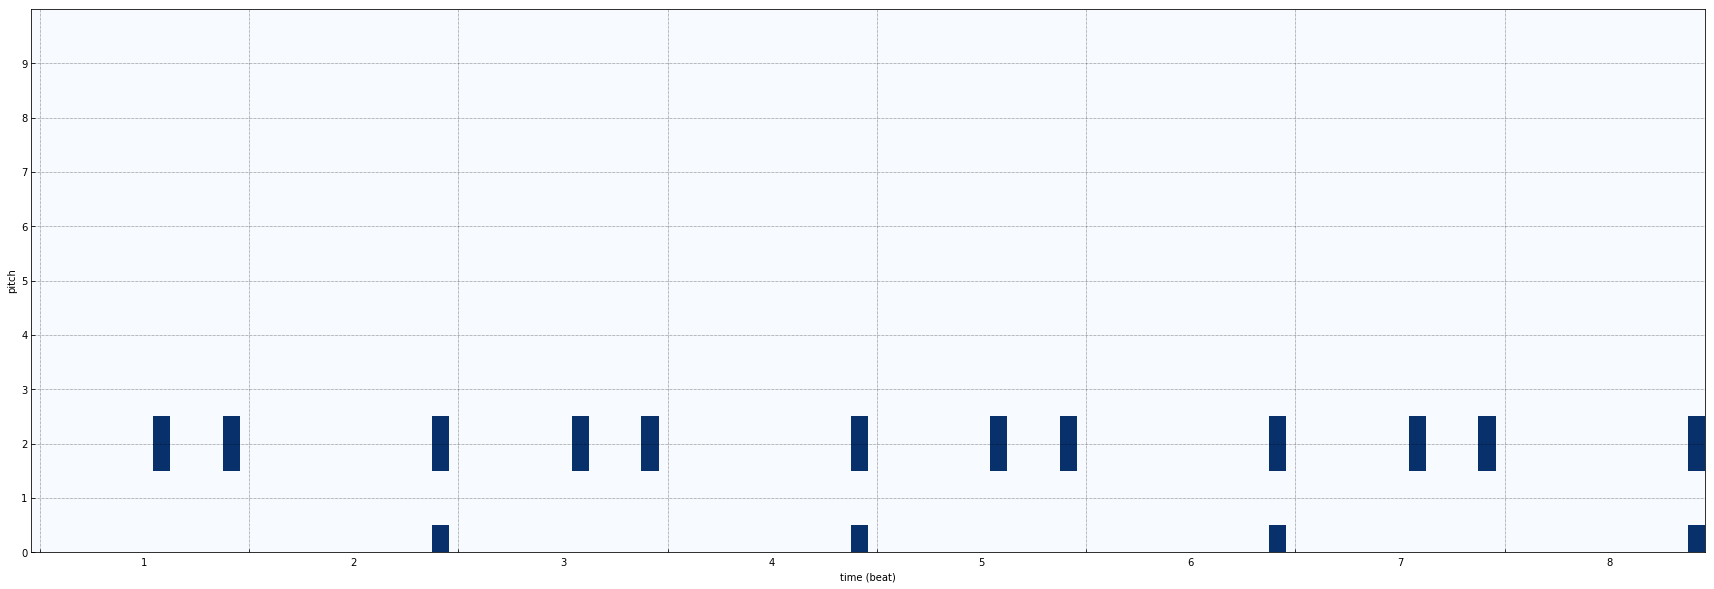

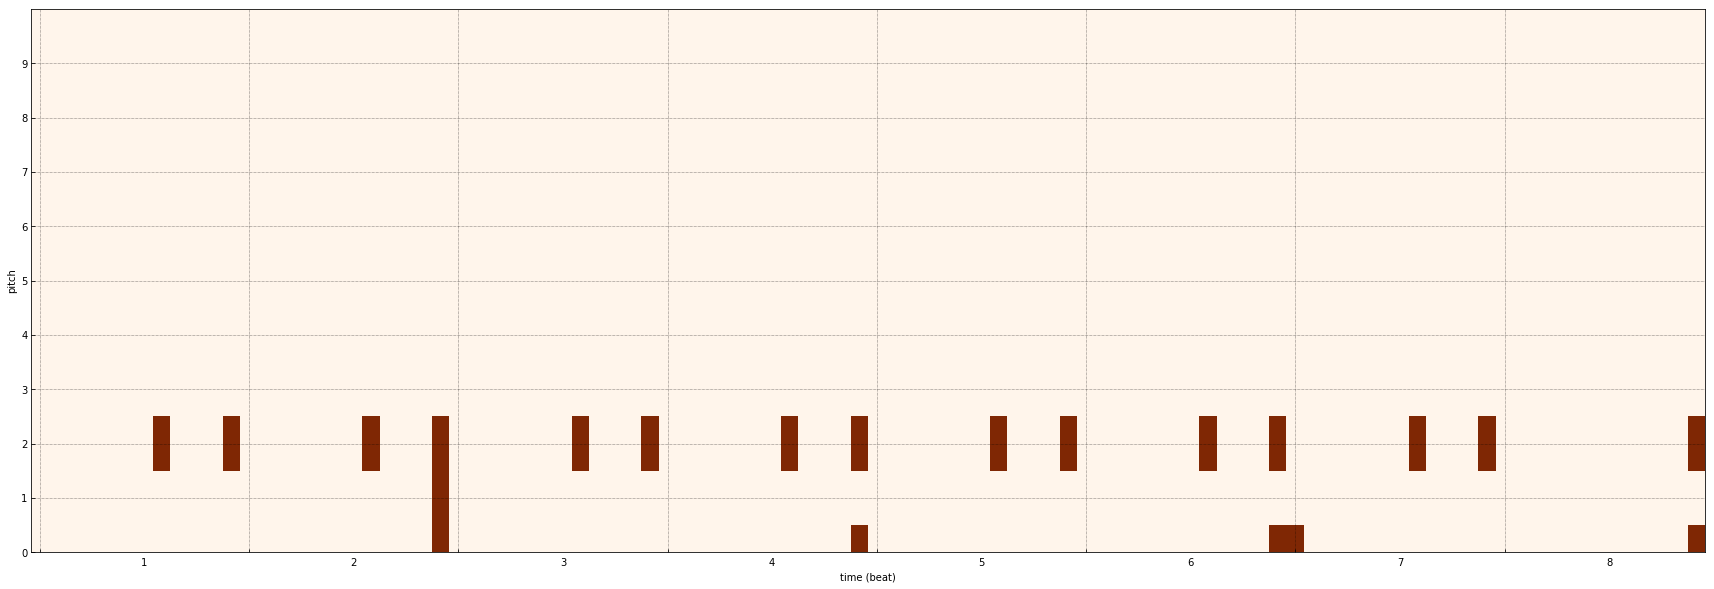

0.761593 7.024442e-12


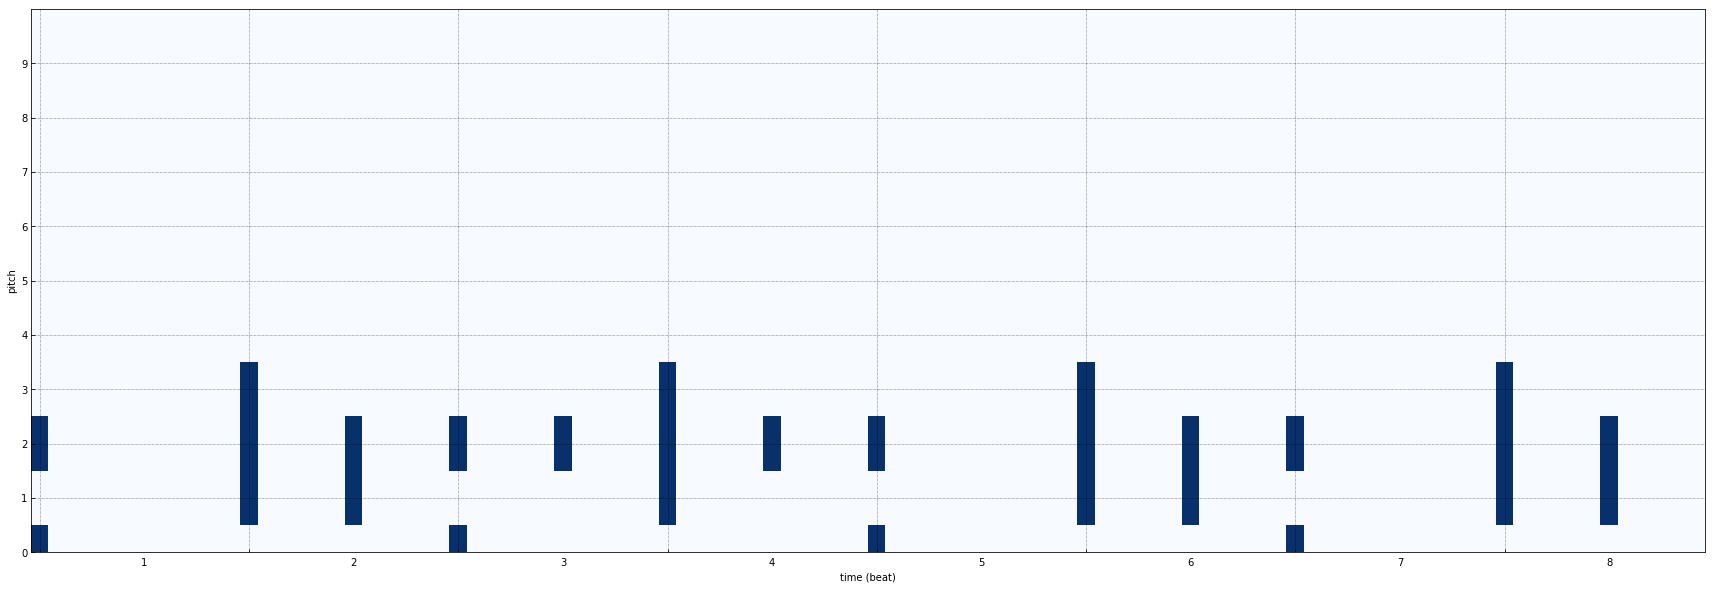

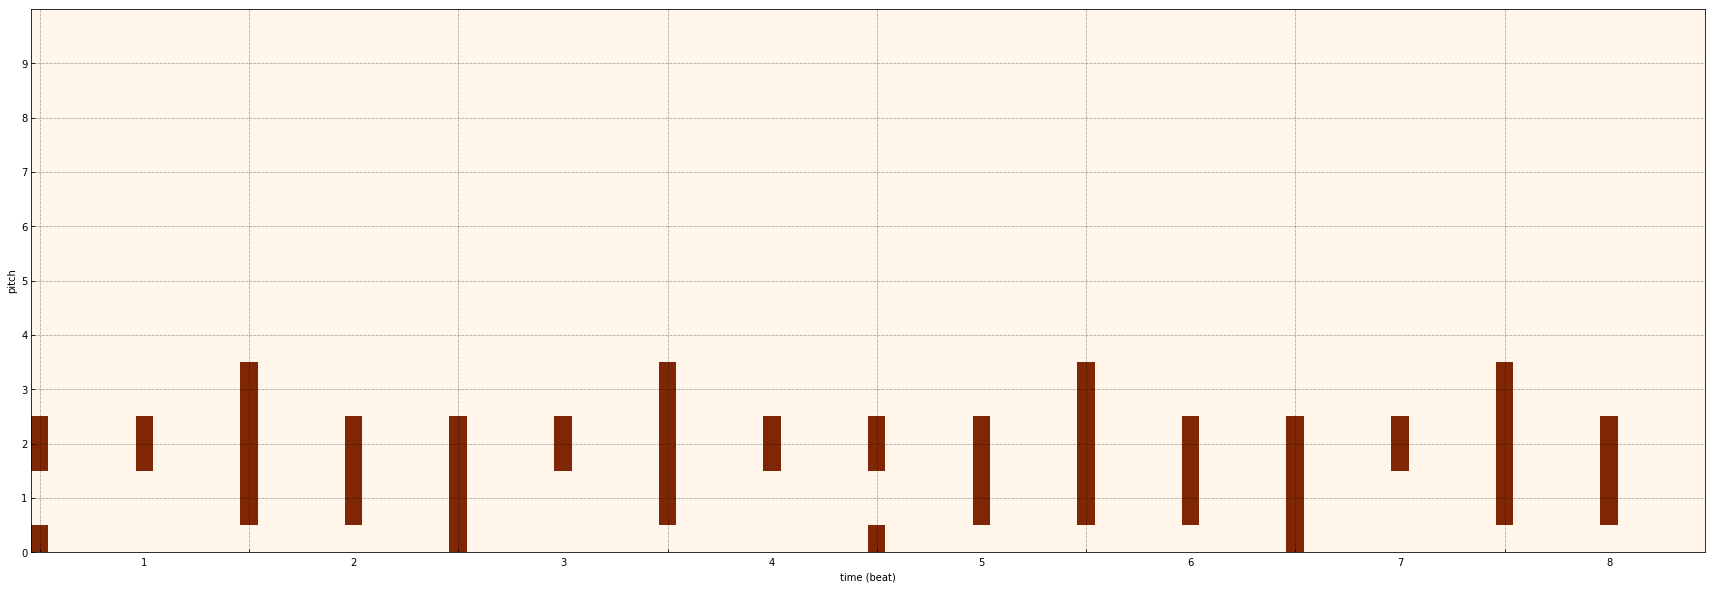

0.76159334 2.2260999e-11


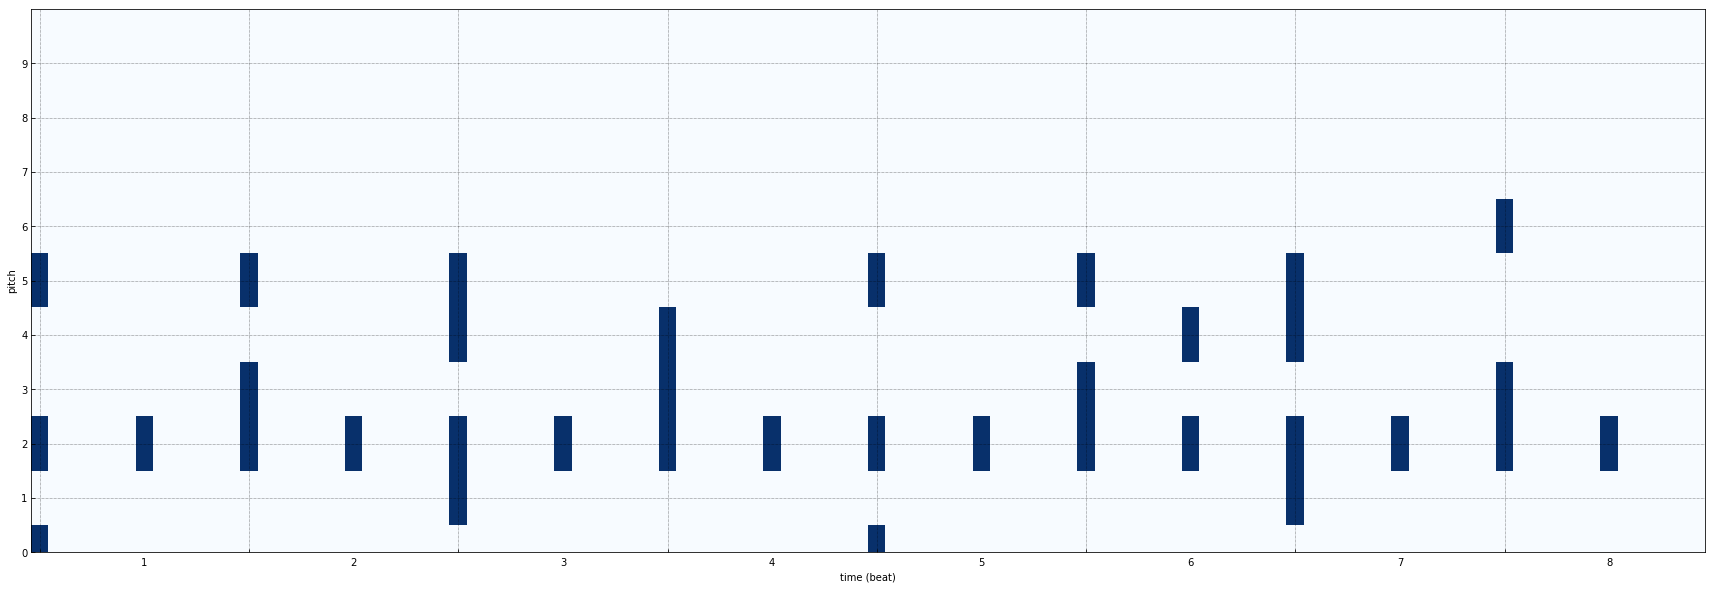

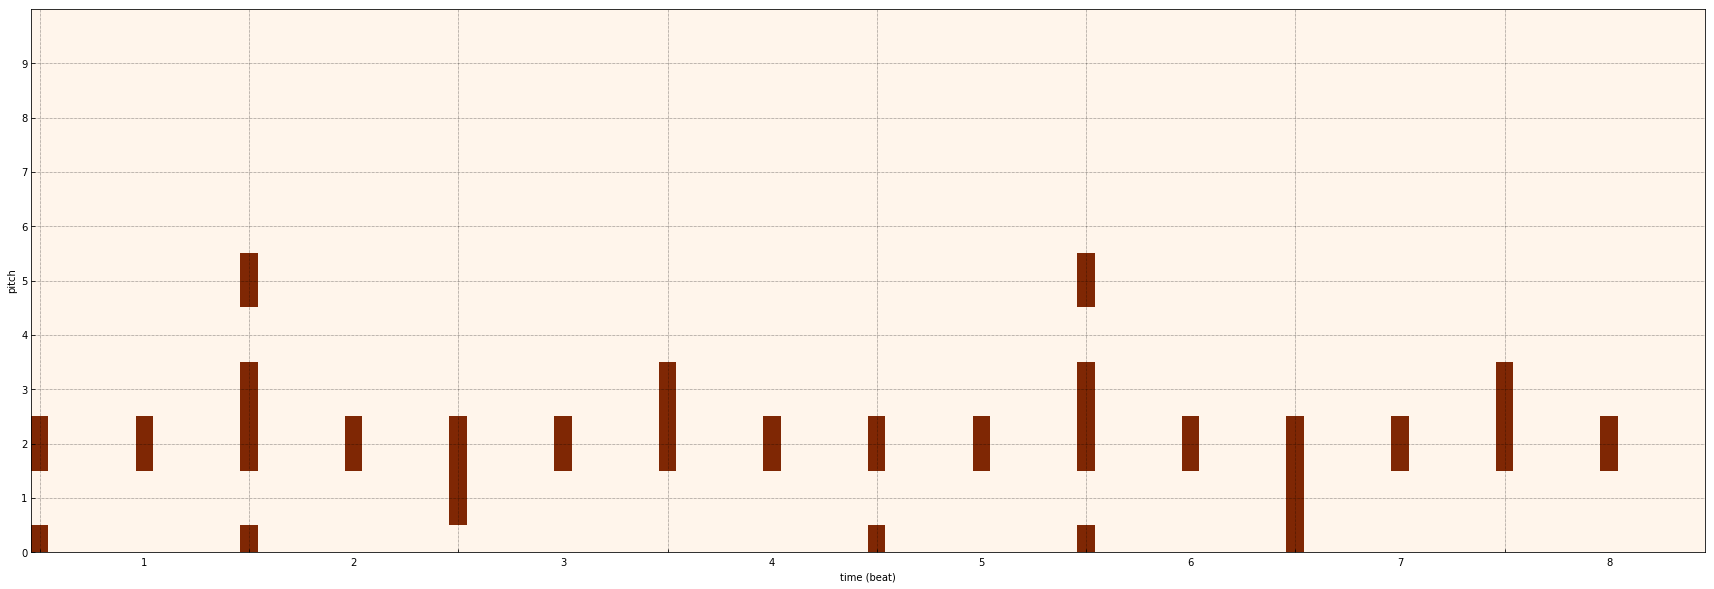

In [15]:
for batch_i, data in enumerate(test_loader):
    if batch_i > 0:
        break
    with torch.no_grad():
        data = Variable(data[0]).type(torch.float32).to(device)
        data_out = vae(data)
        
        
        for i in range(len(data)):
            if i < 20:
                data_i = data[i].cpu().data.numpy()
                data_o = data_out[i].cpu().data.numpy()
                print(data_o.max(), data_o.min())
                data_o = np.where(data_o > 0.2, 1, 0)
                pltReducedDrumTrack(data_i)
                pltReducedDrumTrack(data_o, cmap='Oranges')